<a href="https://colab.research.google.com/github/wh153/IDS705FinalProject/blob/main/IDS705FinalNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDS705 Final Project: Road Sign Classification in Extreme Driving Conditions

## Load and Prepare Data
In this section of the notebook, we imported the two datasets we used from Kaggle. We loaded, merged, reshaped, and relabled the data for classification. They datasets contains images in various sizes, so we reshaped all images to (48, 48, 3). We also created a train, validation, and test dataset in this section.

In [ ]:
%%capture
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
! unzip gtsrb-german-traffic-sign.zip

In [ ]:
%%capture
! kaggle datasets download andrewmvd/road-sign-detection
! unzip road-sign-detection.zip

In [ ]:
## Open Andrew Dataset and load images to array and lose classification to arrays

import pandas as pd
import os
import numpy as np
import xml.etree.ElementTree as ET
from matplotlib import image
from matplotlib import pyplot
from PIL import Image

directory = 'annotations'
fileNames = []
fileClassifications = []

for filename in os.scandir(directory):
    xmlParsed = ET.parse(filename.path)
    fileNames.append(xmlParsed.find('filename').text)
    fileClassifications.append(xmlParsed.find('object').find('name').text)

allImages = []

imgDirectory = 'images'
for name in fileNames:
    im = Image.open('{}/{}'.format(imgDirectory,name))
    im = im.resize((48, 48))
    im = np.asarray(im, dtype=np.uint8)
    im = im[:,:, 0:3]
    allImages.append(im)

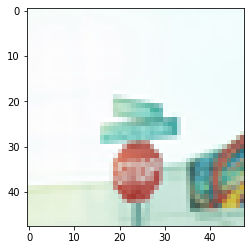

In [ ]:
pyplot.imshow(allImages[50])
pyplot.show()

In [ ]:
## Remap word classifiations into numbers

fileClassifications = np.where(fileClassifications == 'stop', 1, fileClassifications)
fileClassifications = np.where(fileClassifications == 'stop', 1, fileClassifications)
fileClassifications = np.where(fileClassifications == 'crosswalk', 2, fileClassifications)
fileClassifications = np.where(fileClassifications == 'trafficlight', 3, fileClassifications)
fileClassifications = np.where(fileClassifications == 'speedlimit', 0, fileClassifications) 
np.unique(fileClassifications)

array(['0', '1', '2', '3'], dtype='<U12')

In [ ]:
fileClassifications = fileClassifications.astype(int)

In [ ]:
# split train, validation, test dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(allImages, fileClassifications, test_size=.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.25)

In [ ]:
# read GTSRB data
meta = pd.read_csv('Meta.csv')
trainGerman = pd.read_csv('Train.csv')
testGerman = pd.read_csv('Test.csv')

# look for 0-3 Speed Limit, 14 - Stop, 27 - Crosswalk
# select class id: 0, 1, 2, 3, 14, 27
# modify class labels 
classID = [0, 1, 2, 3, 14, 27]
trainGerman = trainGerman.loc[trainGerman['ClassId'].isin(classID)]
print('Train Size: ' + str(trainGerman.shape))
testGerman = testGerman.loc[testGerman['ClassId'].isin(classID)]
print('Test Size: ' + str(testGerman.shape))

# 0 - speed limit, 1 - stopsign, 2 cross walk
trainGerman['ClassId'] = trainGerman['ClassId'].replace({0:0, 2:0, 3:0, 14:1, 27:2})
testGerman['ClassId'] = testGerman['ClassId'].replace({0:0, 2:0, 3:0, 14:1, 27:2})

# load image data and prepare for preprocessing
train_path = trainGerman['Path']
trainGerman_imgs = []
for path in train_path:
  im = Image.open(path)
  im = im.resize((48, 48))
  trainGerman_imgs.append(np.asarray(im, dtype=np.uint8))

trainGerman_imgs = np.array(trainGerman_imgs, dtype=np.uint8)
trainGerman_y = np.array(trainGerman['ClassId'])

# load image data and prepare for preprocessing
test_path = testGerman['Path']
testGerman_imgs = []
for path in test_path:
  im = Image.open(path)
  im = im.resize((48, 48))
  testGerman_imgs.append(np.asarray(im, dtype=np.uint8))

testGerman_imgs = np.array(testGerman_imgs)
test_y = np.array(testGerman['ClassId'])

Train Size: (7110, 8)
Test Size: (2310, 8)


In [ ]:
# Create train-validation Split
xGerman_train, xGerman_val, yGerman_train, yGerman_val = train_test_split(trainGerman_imgs, trainGerman_y, test_size=.25)

In [ ]:
## Combine the Two Datasets
x_train_all = np.concatenate((x_train, xGerman_train), axis=0)
x_test_all = np.concatenate((x_test, testGerman_imgs), axis=0)
x_val_all = np.concatenate((x_val, xGerman_val), axis=0)
y_train_all = np.concatenate((y_train, yGerman_train), axis=0)
y_test_all = np.concatenate((y_test, test_y), axis=0)
y_val_all = np.concatenate((y_val, yGerman_val), axis=0)
print(np.shape(x_train_all))
print(np.shape(y_train_all))

(5824, 48, 48, 3)
(5824,)


In [ ]:
pd.Series(y_val_all).value_counts()

0    1088
1     765
2      82
3       8
dtype: int64

In [ ]:
pd.Series(y_test_all).value_counts()

0    1433
1    1003
2      78
3      16
dtype: int64

## Data Augmentation

In [ ]:
## Normalize all data

def normalize(x_label):
    return (x_label-127.5)/127.5

X_train_normalized=  normalize(x_train_all)
X_test_normalized=  normalize(x_test_all)
X_valid_normalized= normalize(x_val_all)

X_train = X_train_normalized
X_test = X_test_normalized
X_valid= X_valid_normalized

In [ ]:
## Setup data genenerators for each dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

valGen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

testGen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)


## Initial Modeling

### LeNet
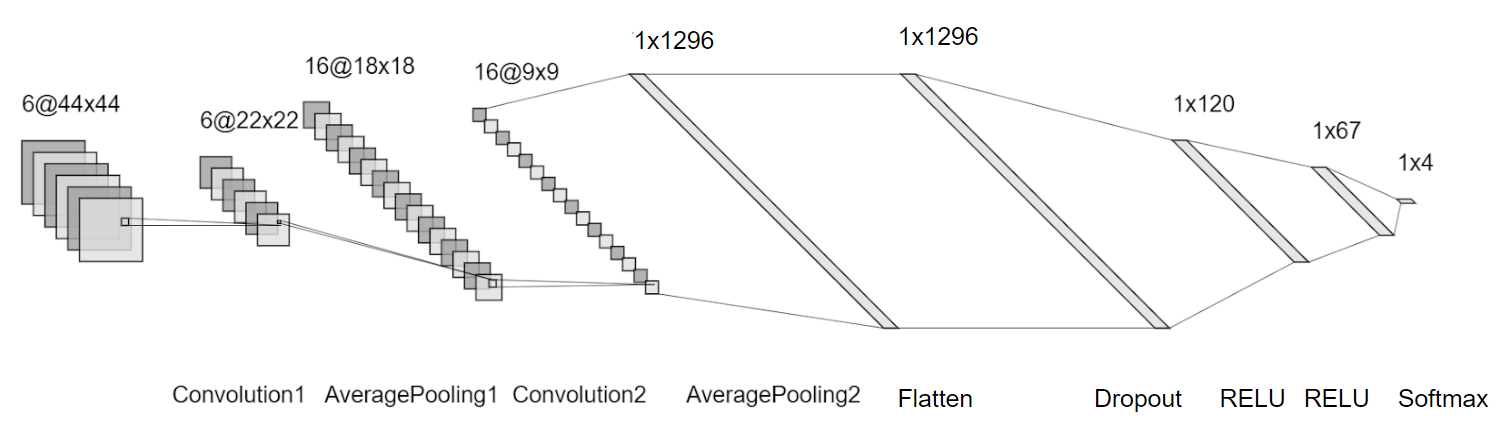


In [ ]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_all, y_train_all))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val_all, y_val_all))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
    tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
    tf.keras.layers.Flatten(name = 'flatten'),
    tf.keras.layers.Dropout(0.5, name = '1st_dropout'),
    tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
    tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
    tf.keras.layers.Dense(4, name = '3rd_fc', activation = 'softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_conv (Conv2D)           (None, 44, 44, 6)         456       
                                                                 
 1st_pooling (AveragePooling  (None, 22, 22, 6)        0         
 2D)                                                             
                                                                 
 2nd_conv (Conv2D)           (None, 18, 18, 16)        2416      
                                                                 
 2nd_pooling (AveragePooling  (None, 9, 9, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1296)              0         
                                                                 
 1st_dropout (Dropout)       (None, 1296)             

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_sparse_categorical_accuracy', 
    patience = 10, 
    mode = 'auto'
)
history = model.fit(
    train_dataset,
    epochs=30,
    callbacks = [callbacks],
    validation_data=test_dataset,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


89/91 [============================>.] - ETA: 0s - loss: 2.5117 - sparse_categorical_accuracy: 0.6503

KeyboardInterrupt: ignored

In [ ]:
y_pred = np.argmax(model.predict(x_test_all),axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_test_all, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### LetNet with Data Augmentation

In [ ]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_all, y_train_all))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val_all, y_val_all))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
    tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
    tf.keras.layers.Flatten(name = 'flatten'),
    tf.keras.layers.Dropout(0.5, name = '1st_dropout'),
    tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
    tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
    tf.keras.layers.Dense(4, name = '3rd_fc', activation = 'softmax')
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_sparse_categorical_accuracy', 
    patience = 10, 
    mode = 'auto'
)
history = model.fit(
    trainGen.flow(X_train, y_train_all, batch_size=64),
    validation_data=valGen.flow(X_valid, y_val_all, ),
    epochs=30,
    callbacks = [callbacks],
)

In [ ]:
y_pred = np.argmax(model.predict(X_test),axis=1)

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_all, y_pred)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Hyperparameter Tuning

In [ ]:
def create_model(optimizer='adam', learning_rate=0.001):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
    tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
    tf.keras.layers.Flatten(name = 'flatten'),
    tf.keras.layers.Dropout(0.2, name = '1st_dropout'),
    tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
    tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
    tf.keras.layers.Dense(3, activation = 'softmax', name = '3rd_fc')
  ])
  if optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  else:
        raise ValueError('optimizer {} unrecognized'.format(optimizer))
  
  model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
  )
  
  return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

model = KerasClassifier(build_fn=create_model, verbose=0)
batch_size = [64, 128, 200]
epochs = [20, 30, 50]
learning_rate = [0.001, 0.01, 0.1]

param_grid = dict(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, error_score='raise')
grid_result = grid.fit(x_train_all, y_train_all)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.661877 using {'batch_size': 200, 'epochs': 50, 'learning_rate': 0.001}
0.647459 (0.142096) with: {'batch_size': 64, 'epochs': 20, 'learning_rate': 0.001}
0.558032 (0.017353) with: {'batch_size': 64, 'epochs': 20, 'learning_rate': 0.01}
0.558032 (0.017353) with: {'batch_size': 64, 'epochs': 20, 'learning_rate': 0.1}
0.649690 (0.145247) with: {'batch_size': 64, 'epochs': 30, 'learning_rate': 0.001}
0.558032 (0.017353) with: {'batch_size': 64, 'epochs': 30, 'learning_rate': 0.01}
0.558032 (0.017353) with: {'batch_size': 64, 'epochs': 30, 'learning_rate': 0.1}
0.654668 (0.152276) with: {'batch_size': 64, 'epochs': 50, 'learning_rate': 0.001}
0.557860 (0.017138) with: {'batch_size': 64, 'epochs': 50, 'learning_rate': 0.01}
0.557860 (0.017138) with: {'batch_size': 64, 'epochs': 50, 'learning_rate': 0.1}
0.657757 (0.156640) with: {'batch_size': 128, 'epochs': 20, 'learning_rate': 0.001}
0.558032 (0.017353) with: {'batch_size': 128, 'epochs': 20, 'learning_rate': 0.01}
0.558032 (0.0173

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
  tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
  tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
  tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
  tf.keras.layers.Flatten(name = 'flatten'),
  tf.keras.layers.Dropout(0.2, name = '1st_dropout'),
  tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
  tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
  tf.keras.layers.Dense(3, activation = 'softmax', name = '3rd_fc')
])

model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=["accuracy"],
)



ROC AUC score: 0.774126304392748


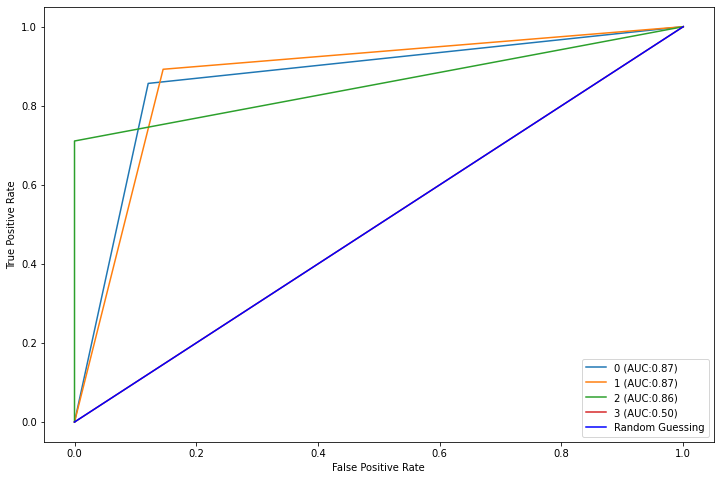

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target= [0,1,2,3]
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
print('ROC AUC score:', multiclass_roc_auc_score(y_test_all, y_pred))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

### Resnet Models

#### Resnet 18

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(np.asarray(y_train_all)))
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(np.asarray(y_test_all)))
batch_size = 128
val_size = 1000

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = models.resnet18(pretrained=True).float()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.cuda() if device else net
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 4)
net.fc = net.fc.cuda() if device else net.fc


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        data_ = torch.permute(data_, (0, 3, 1,2))
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            data_t = torch.permute(data_t, (0, 3, 1,2))
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/30], Step [0/46], Loss: 1.9300
Epoch [1/30], Step [20/46], Loss: 1.8232
Epoch [1/30], Step [40/46], Loss: 1.6819

train-loss: 1.7831, train-acc: 16.0371
validation loss: 1.6364, validation acc: 22.8854

Improvement-Detected, save-model
Epoch 2

Epoch [2/30], Step [0/46], Loss: 1.5823
Epoch [2/30], Step [20/46], Loss: 1.5361
Epoch [2/30], Step [40/46], Loss: 1.5102

train-loss: 1.6449, train-acc: 29.8592
validation loss: 1.5455, validation acc: 37.8656

Improvement-Detected, save-model
Epoch 3

Epoch [3/30], Step [0/46], Loss: 1.4578
Epoch [3/30], Step [20/46], Loss: 1.2366
Epoch [3/30], Step [40/46], Loss: 1.2166

train-loss: 1.5281, train-acc: 43.3723
validation loss: 1.4725, validation acc: 47.4308

Improvement-Detected, save-model
Epoch 4

Epoch [4/30], Step [0/46], Loss: 1.2819
Epoch [4/30], Step [20/46], Loss: 1.1583
Epoch [4/30], Step [40/46], Loss: 1.0330

train-loss: 1.4271, train-acc: 54.7905
validation loss: 1.3990, validation acc: 55.6126

Improvement-Detec

In [ ]:
data_t = torch.from_numpy(X_test).float()
data_t = data_t.to(device)
data_t = torch.permute(data_t, (0, 3, 1,2))
outputs_t = net(data_t)
_,pred_t = torch.max(outputs_t, dim=1)

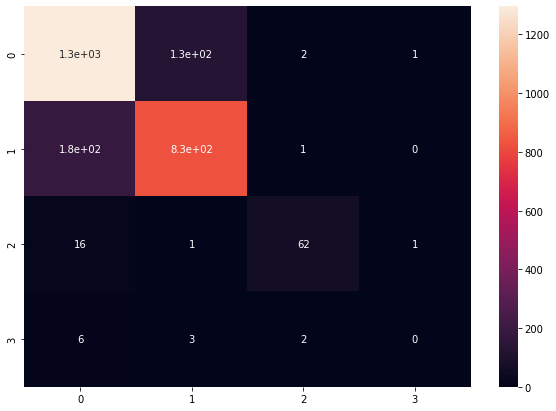

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_all, pred_t.cpu())
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

ROC AUC score: 0.8879912961066702


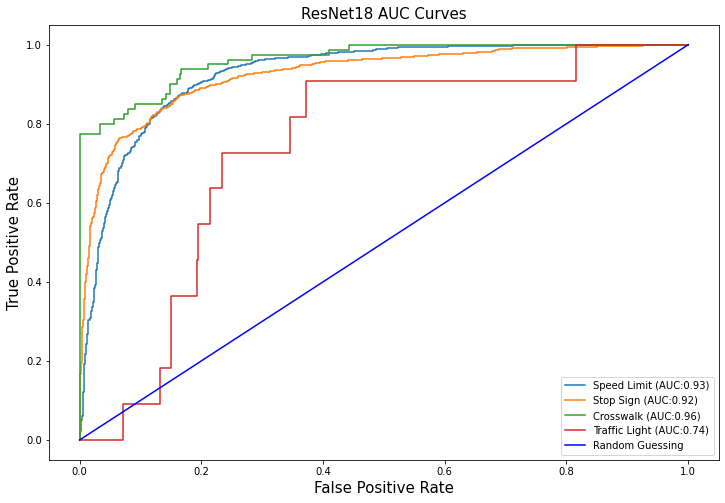

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target= [0,1,2,3]
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
# function for scoring roc auc score for multi-class

def multiclass_roc_auc_score(y_test, y_pred, ax, title, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  c_labels = ['Speed Limit', 'Stop Sign', 'Crosswalk', 'Traffic Light']
  #y_pred = lb.transform(y_pred)
  for (idx, pred) in enumerate(y_pred.transpose()):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), pred)
      ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_labels[idx], auc(fpr, tpr)))
  ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  ax.legend(fontsize = 15)
  ax.set_title(title, fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 15)
  ax.set_ylabel('True Positive Rate', fontsize = 15)
  return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test_all, outputs_t.cpu().detach().numpy(), c_ax, 'ResNet18 AUC Curves'))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

#### Resnet 50

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(np.asarray(y_train_all)))
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(np.asarray(y_test_all)))
batch_size = 128
val_size = 1000

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = models.resnet50(pretrained=True).float()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.cuda() if device else net
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 4)
net.fc = net.fc.cuda() if device else net.fc

In [ ]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        data_ = torch.permute(data_, (0, 3, 1,2))
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            data_t = torch.permute(data_t, (0, 3, 1,2))
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/30], Step [0/46], Loss: 1.4773
Epoch [1/30], Step [20/46], Loss: 1.4086
Epoch [1/30], Step [40/46], Loss: 1.3869

train-loss: 1.4194, train-acc: 31.3187
validation loss: 1.3748, validation acc: 35.6522

Improvement-Detected, save-model
Epoch 2

Epoch [2/30], Step [0/46], Loss: 1.3497
Epoch [2/30], Step [20/46], Loss: 1.3170
Epoch [2/30], Step [40/46], Loss: 1.2487

train-loss: 1.3626, train-acc: 41.3805
validation loss: 1.3396, validation acc: 42.8854

Improvement-Detected, save-model
Epoch 3

Epoch [3/30], Step [0/46], Loss: 1.2051
Epoch [3/30], Step [20/46], Loss: 1.2211
Epoch [3/30], Step [40/46], Loss: 1.1535

train-loss: 1.3081, train-acc: 51.0302
validation loss: 1.3027, validation acc: 49.8814

Improvement-Detected, save-model
Epoch 4

Epoch [4/30], Step [0/46], Loss: 1.1546
Epoch [4/30], Step [20/46], Loss: 1.1007
Epoch [4/30], Step [40/46], Loss: 1.0850

train-loss: 1.2542, train-acc: 62.4141
validation loss: 1.2656, validation acc: 56.4822

Improvement-Detec

#### Resnet 101

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(np.asarray(y_train_all)))
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(np.asarray(y_test_all)))
batch_size = 128
val_size = 1000

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = models.resnet101(pretrained=True).float()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.cuda() if device else net
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 4)
net.fc = net.fc.cuda() if device else net.fc

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        data_ = torch.permute(data_, (0, 3, 1,2))
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            data_t = torch.permute(data_t, (0, 3, 1,2))
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/30], Step [0/46], Loss: 1.4738
Epoch [1/30], Step [20/46], Loss: 1.4463
Epoch [1/30], Step [40/46], Loss: 1.3031

train-loss: 1.4024, train-acc: 36.2981
validation loss: 1.3412, validation acc: 41.9763

Improvement-Detected, save-model
Epoch 2

Epoch [2/30], Step [0/46], Loss: 1.3095
Epoch [2/30], Step [20/46], Loss: 1.2829
Epoch [2/30], Step [40/46], Loss: 1.1671

train-loss: 1.3353, train-acc: 45.3984
validation loss: 1.2997, validation acc: 49.6047

Improvement-Detected, save-model
Epoch 3

Epoch [3/30], Step [0/46], Loss: 1.2016
Epoch [3/30], Step [20/46], Loss: 1.1287
Epoch [3/30], Step [40/46], Loss: 1.0981

train-loss: 1.2747, train-acc: 56.9025
validation loss: 1.2575, validation acc: 57.7075

Improvement-Detected, save-model
Epoch 4

Epoch [4/30], Step [0/46], Loss: 1.0961
Epoch [4/30], Step [20/46], Loss: 1.0390
Epoch [4/30], Step [40/46], Loss: 1.0727

train-loss: 1.2183, train-acc: 68.2177
validation loss: 1.2187, validation acc: 63.9921

Improvement-Detec

# Road Condition Simulations
In this section, we simulated low visibility road conditions with Python. We simulated four conditions, rain, fog, extreme dark, and extreme bright. These functions will be called later in the experimental sections.


In [ ]:
import pandas as pd
from PIL import Image, ImageEnhance, ImageFilter 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import random
import cv2

In [ ]:
# generate rain effect
def generate_random_lines(imshape,slant,drop_length,n_drops):    
  drops=[] # store rain drop locations
  for i in range(n_drops): ## If You want heavy rain, try increasing this        
    if slant<0:   
      # generate degree of the rain drop         
      x= np.random.randint(slant,imshape[1])        
    else:  
      # generate location of rain drop         
      x= np.random.randint(0,imshape[1]-slant)        
      y= np.random.randint(0,imshape[0]-drop_length)        
      drops.append((x,y))    
  return drops            
    
def add_rain(image, drop_length, drop_width, n_drops):  
  # copy image to prevent original image overwrite
  new_img = image.copy()
  
  # rain drops setting
  slant_extreme = 5
  slant= np.random.randint(1,slant_extreme)  
  drop_color=(230,230,230) ## a shade of light gray    
  imshape = new_img.shape 
  rain_drops= generate_random_lines(imshape,slant,drop_length, n_drops)
  
  # add rain drops to image 
  for rain_drop in rain_drops: 
    new_img = cv2.line(new_img,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),drop_color,drop_width)
  
  #new_img = cv2.UMat.get(new_img)
  new_img = cv2.blur(new_img,(1,1)) # blur image 
  new_img = np.floor(new_img*0.9) # bring down image brightness 
  new_img = new_img.astype(int) # convert image back into int format
  return new_img

# generate fog effect
def gen_patches(imshape, num):
  # randomly generate size of fog patch
  h, w = np.ceil(np.array(imshape[:2])*0.15).astype(int)
  index = 0
  
  # generate location of fog patches
  shapes = []
  while index < num:
    y = np.random.choice(list(range(imshape[0]))) # how many rows of pixels
    x = np.random.choice(list(range(imshape[1]))) # how many columns of pixels
    if x + h < (imshape[1]) and y + w < imshape[0]:
      index += 1
      shape = (y, y + h, x, x + w)
      shapes.append(shape)
  return shapes

def get_black_pixels(image):
  # find location of all black pixels 
  imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')
  pixels = imagePIL.getdata()
  nblack = 0
  for pixel in pixels:
    if sum(pixel) == 0:
      nblack += 1
  percent_black = nblack/len(pixels)
  return percent_black

def reduce_black_pixels1(img):
  # impute black pixels with gray pixels
  image = img.copy()
  threshold_level = 50
  image = image.astype(np.uint8)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  coords = np.column_stack(np.where(gray < threshold_level)) # find coords of pixels that are black

  # t
  indexLst = random.sample(list(range(len(coords))), int(len(coords)*0.2))
  for index in indexLst:
    loc = coords[index]
    image[loc[0], loc[1],:] += random.randint(100, 180)
  return image

def add_fog(img, patches = 50):
  image = img.copy()
  # step 0: check for black pixel components
  percent = get_black_pixels(image)
  if percent >= 0.25:
      image = reduce_black_pixels1(image)
      
  # step 1: generate patches
  patches = gen_patches(image.shape, patches)

  # step 2: blur each patches
  for p in patches:
    imagePatch = image[p[0]:p[1],p[2]:p[3]] # create variable name
    imagePatch = cv2.blur(imagePatch, ksize = (1, 1)) # blur image

    # convert patch to PIL
    imagePatchPIL = Image.fromarray(np.uint8(imagePatch)).convert('RGB')

    # increase brightness of the patch
    enhancer = ImageEnhance.Brightness(imagePatchPIL)
    imagePatchPIL = enhancer.enhance(1.1)

    # reduce saturation of the patch
    enhancer = ImageEnhance.Color(imagePatchPIL)
    imagePatchPIL = enhancer.enhance(0.6)

    # convert PIL back to array
    image[p[0]:p[1],p[2]:p[3]] = np.array(imagePatchPIL)

  # step 4: reduce brightness
  imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')
  enhancer = ImageEnhance.Brightness(imagePIL)
  imagePIL = enhancer.enhance(0.8)

  # step 5: reduce saturation
  enhancer = ImageEnhance.Color(imagePIL)
  imagePIL = enhancer.enhance(0.7)
  
  # step 6: apply median filter
  imagePIL = imagePIL.filter(ImageFilter.MedianFilter(size = 5)) 

  # step 7: reduce brightness
  imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')

  # step 8: convert PIL back to array
  image = cv2.blur(np.array(imagePIL), ksize = (1, 1))

  return image

# generate extreme darkness
def extreme_dark(img):
  image = img.copy()
  imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')
  
  # reduce brightness
  enhancer = ImageEnhance.Brightness(imagePIL)
  imagePIL = enhancer.enhance(0.85)
  
  # reduce satuation
  enhancer = ImageEnhance.Color(imagePIL)
  imagePIL = enhancer.enhance(0.85)
  
  # add slight blur
  image = np.array(imagePIL)
  image = cv2.blur(image, (1, 1))
  return image

# generate extreme brightness
def reduce_black_pixels2(img):
  # impute black pixels with gray pixels
  image = img.copy()
  threshold_level = 50
  image = image.astype(np.uint8)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  coords = np.column_stack(np.where(gray < threshold_level)) # find coords of pixels that are black
  indexLst = random.sample(list(range(len(coords))), int(len(coords)*0.8))
  for index in indexLst:
    loc = coords[index]
    image[loc[0], loc[1],:] += random.randint(100, 180)
  return image

def extreme_bright(img):
  image = img.copy()
  
  # check for black pixel components
  percent = get_black_pixels(image)
  if percent >= 0.25:
    image = reduce_black_pixels2(image)
  
  imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')
  
  # reduce satuation
  enhancer = ImageEnhance.Color(imagePIL)
  imagePIL = enhancer.enhance(0.7)
  
  # increase brightness
  enhancer = ImageEnhance.Brightness(imagePIL)
  imagePIL = enhancer.enhance(1.9)

  
  # add slight blur
  image = np.array(imagePIL)
  image = cv2.blur(image, (1, 1))
  return image

# Model Experimentation
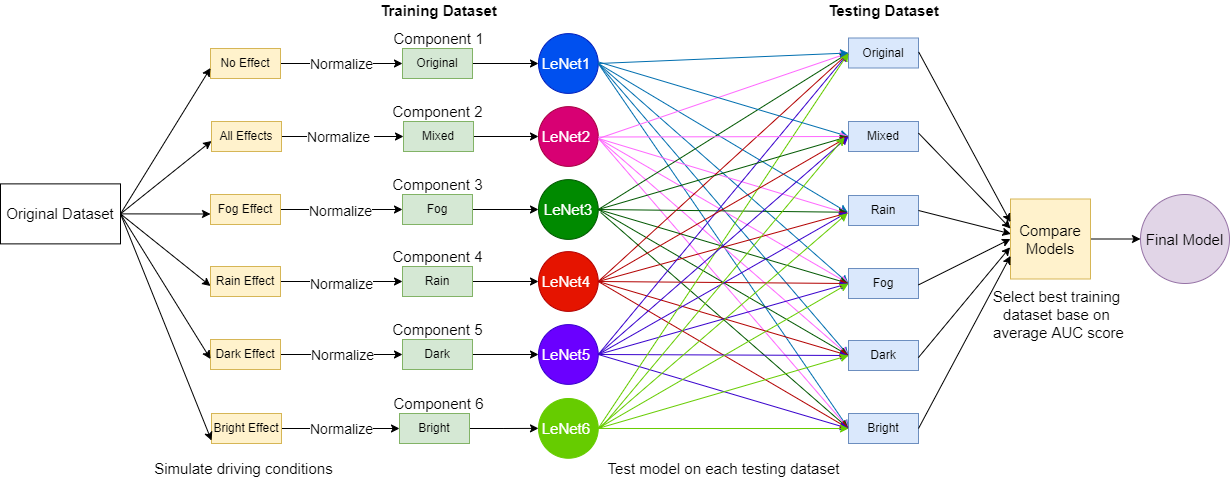

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
# define helper funtions
def add_effect(image, effect):
  """
  Apply image effects to images
  input:
        - image: a single image in np.array format
        - effect: image effect, none, rain, fog, dark, bright

  output:
        - processed image in np.array format
  """
  img = image.copy()
  if effect == None:
    return img
  elif effect == 'rain':
    return add_rain(img, 1, 1, 40)
  elif effect == 'fog':
    return add_fog(img, 60)
  elif effect == 'dark':
    return extreme_dark(img)
  elif effect == 'bright':
    return extreme_bright(img)

def normalize(x_label):
  # normalize images
  return (x_label-127.5)/127.5

def multiclass_roc_auc_score(y_test, y_pred, ax, title, average="macro"):
  """
  input:
        - y_test: actual y labels
        - y_pred: predicted y probabilities mx4 matrix, m is images count
        - ax: ax to plot on
        - title: title of the plot
  """
  # convert multiclass labels to binary form
  lb = LabelBinarizer() 
  lb.fit(y_test)
  y_test = lb.transform(y_test)

  # define image class labels for plotting
  c_labels = ['Speed Limit', 'Stop Sign', 'Crosswalk', 'Traffic Light']

  # loop thru 4 classes and plot ROC
  for (idx, pred) in enumerate(y_pred.transpose()):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), pred)
      ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_labels[idx], auc(fpr, tpr)))
  ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  ax.legend(fontsize = 15)
  ax.set_title(title, fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 15)
  ax.set_ylabel('True Positive Rate', fontsize = 15)
  return roc_auc_score(y_test, y_pred, average=average)

def generate_mixed_dataset(imgs):
  """
  Generate datasets with 20% original, 20% rain, 20% fog, 20% dark, and 20% bright
  input:
        - imgs: an array of images that you want to tranform
  output:
        - images: transformed images
  """
  # get randomized index
  images = imgs.copy()

  index = list(range(images.shape[0]))
  random.seed(0)
  random.shuffle(index)

  # divide in to equal partition
  size = images.shape[0]//5 # floor division
  ori_index = index[0:size]
  rain_index = index[size:size*2]
  fog_index = index[size*2:size*3]
  dark_index = index[size*3:size*4]
  bright_index = index[size*4:]
  
  effects = [None, 'rain', 'fog', 'dark', 'bright' ]
  index = [ori_index, rain_index, fog_index, dark_index, bright_index]
  # process training image
  for ind, effect in zip(index, effects):
    for i in ind:
      images[i] = add_effect(images[i], effect)
  return images


In [ ]:
# define model constant
BATCH_SIZE = 200
SHUFFLE_BUFFER_SIZE = 100

# model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
    tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
    tf.keras.layers.Flatten(name = 'flatten'),
    tf.keras.layers.Dropout(0.5, name = '1st_dropout'),
    tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
    tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
    tf.keras.layers.Dense(4, name = '3rd_fc', activation = 'softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_sparse_categorical_accuracy', 
    patience = 10, 
    mode = 'auto'
)

In [ ]:
# define all image effects
effects = [None, 'rain', 'fog', 'dark', 'bright']

# copy training data, testing data, and validation data
x_test = x_test_all.copy()
x_val = x_val_all.copy()

# add effects to the testing images
x_test_rain = []
x_test_fog = []
x_test_dark = []
x_test_bright = []
for img in x_test:
  x_test_rain.append(add_effect(img, 'rain'))
  x_test_fog.append(add_effect(img, 'fog'))
  x_test_dark.append(add_effect(img, 'dark'))
  x_test_bright.append(add_effect(img, 'bright'))

# convert image list to image array
x_test_rain = np.array(x_test_rain)
x_test_fog = np.array(x_test_fog)
x_test_dark = np.array(x_test_dark)
x_test_bright = np.array(x_test_bright)
x_test_mixed = generate_mixed_dataset(x_test_all)

# normalize the images
x_test_ori = normalize(x_test_all)
x_test_rain = normalize(x_test_rain)
x_test_fog = normalize(x_test_fog)
x_test_dark = normalize(x_test_dark)
x_test_bright = normalize(x_test_bright)
x_test_mixed = normalize(x_test_mixed)
x_val = normalize(x_val)

# prepare images to feed into the model
test_ori_dataset = tf.data.Dataset.from_tensor_slices((x_test_all, y_test_all))
test_rain_dataset = tf.data.Dataset.from_tensor_slices((x_test_rain, y_test_all))
test_fog_dataset = tf.data.Dataset.from_tensor_slices((x_test_fog, y_test_all))
test_dark_dataset = tf.data.Dataset.from_tensor_slices((x_test_dark, y_test_all))
test_bright_dataset = tf.data.Dataset.from_tensor_slices((x_test_bright, y_test_all))
test_mixed_dataset = tf.data.Dataset.from_tensor_slices((x_test_mixed, y_test_all))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val_all))

test_ori_dataset = test_ori_dataset.batch(BATCH_SIZE)
test_rain_dataset = test_rain_dataset.batch(BATCH_SIZE)
test_fog_dataset = test_fog_dataset.batch(BATCH_SIZE)
test_dark_dataset = test_dark_dataset.batch(BATCH_SIZE)
test_bright_dataset = test_bright_dataset.batch(BATCH_SIZE)
test_mixed_dataset = test_mixed_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [ ]:
# define auc score storage
# input order: none, rain, fog, dark, bright, mixed
AUC = {
    'original': [],
    'mixed': [],
    'rain': [],
    'fog': [],
    'dark': [],
    'bright': []
}

# Experimental Setup 1: Original
* Train data: original dataset
* Validation data: 
  * Original Validation
  * Rain Validation
  * Fog Validation
  * Dark Validation
  * Bright Validation

In [ ]:
# original train
x_train = x_train_all.copy()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_all))

# prepare dataset for model fit
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# prepare model to original
# model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
    tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
    tf.keras.layers.Flatten(name = 'flatten'),
    tf.keras.layers.Dropout(0.5, name = '1st_dropout'),
    tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
    tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
    tf.keras.layers.Dense(4, name = '3rd_fc', activation = 'softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_sparse_categorical_accuracy', 
    patience = 10, 
    mode = 'auto'
)

history_ori = model.fit(
    train_dataset,
    epochs=20,
    callbacks = [callbacks],
    verbose=0,
    validation_data=val_dataset
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Original Validation: ROC AUC score: 0.9704760751645699
Rain Validation: ROC AUC score: 0.6345086174282922
Fog Validation: ROC AUC score: 0.6520030743060271
Dark Validation: ROC AUC score: 0.6426455462905373
Bright Validation: ROC AUC score: 0.7173802196129007
Mixed Validation: ROC AUC score: 0.6815460265601223


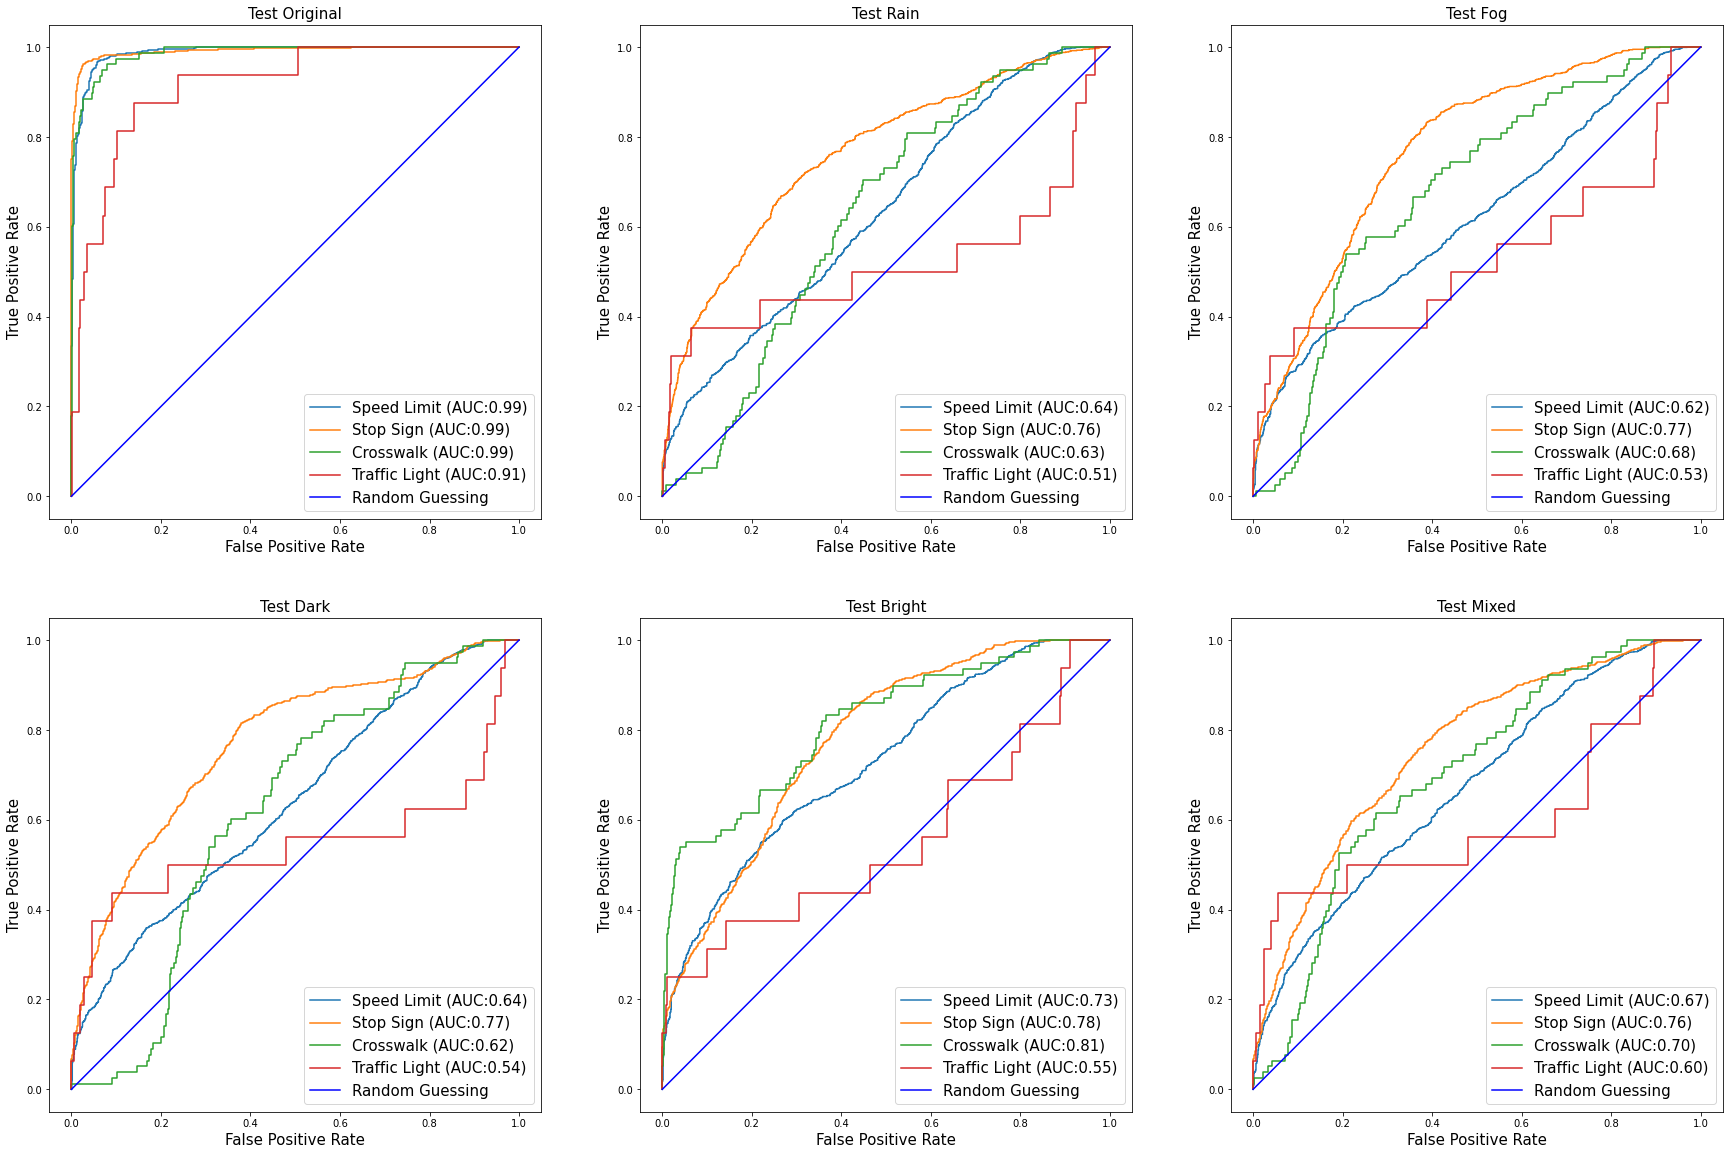

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (30, 20))
# assess validation accuracy on rain
target= [0,1,2,3]

y_pred = model.predict(x_test_all)
auc_ori = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][0], 'Test Original')
print('Original Validation: ROC AUC score:', str(auc_ori))

y_pred = model.predict(x_test_rain)
auc_rain = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][1], 'Test Rain')
print('Rain Validation: ROC AUC score:', str(auc_rain))

y_pred = model.predict(x_test_fog)
auc_fog = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][2], 'Test Fog')
print('Fog Validation: ROC AUC score:', str(auc_fog))

y_pred = model.predict(x_test_dark)
auc_dark = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][0], 'Test Dark')
print('Dark Validation: ROC AUC score:', str(auc_dark))

y_pred = model.predict(x_test_bright)
auc_bright = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][1], 'Test Bright')
print('Bright Validation: ROC AUC score:', str(auc_bright))

y_pred = model.predict(x_test_mixed)
auc_mixed = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][2], 'Test Mixed')
print('Mixed Validation: ROC AUC score:', str(auc_mixed))

auc_lst = [auc_ori, auc_rain, auc_fog, auc_dark, auc_bright, auc_mixed]
AUC['original'] = auc_lst

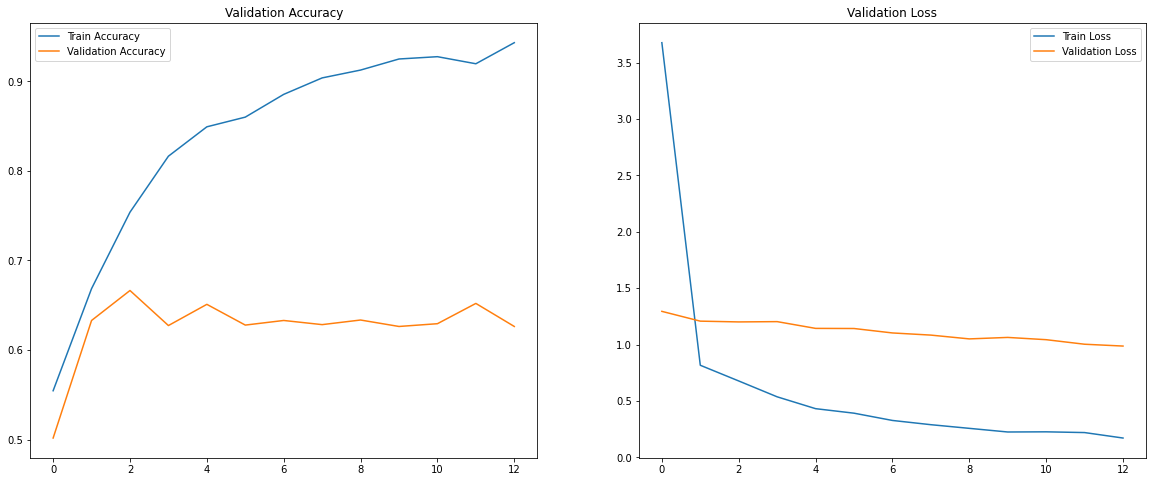

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
# validation accuracy
train_acc =  history_ori.history['sparse_categorical_accuracy']
val_acc =  history_ori.history['val_sparse_categorical_accuracy']

# validation loss
train_loss =  history_ori.history['loss']
val_loss =  history_ori.history['val_loss']

axes[0].plot(train_acc, label = 'Train Accuracy')
axes[0].plot(val_acc, label = 'Validation Accuracy')
axes[1].plot(train_loss, label = 'Train Loss')
axes[1].plot(val_loss, label = 'Validation Loss')
axes[0].set_title('Validation Accuracy')
axes[1].set_title('Validation Loss')
axes[0].legend()
axes[1].legend()

[Text(69.0, 0.5, 'Actual'), Text(0.5, 42.0, 'Predicted')]

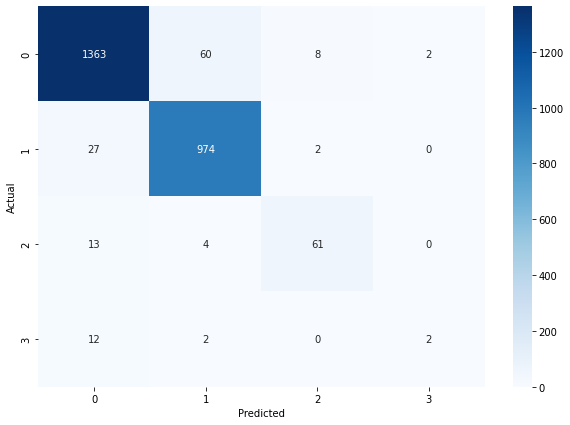

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = np.argmax(model.predict(x_test_all),axis=1)
matrix = confusion_matrix(y_test_all, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
s =sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
s.set(xlabel='Predicted', ylabel='Actual')

# Experimental Setup 2: Mixed
* Train data: Mixed dataset
  * 20% Original
  * 20% Rain
  * 20% Fog
  * 20% Dark
  * 20% Bright
* Validation data: 
  * Original Validation
  * Rain Validation
  * Fog Validation
  * Dark Validation
  * Bright Validation

In [ ]:
# get randomized index
x_train = x_train_all.copy()

index = list(range(x_train.shape[0]))
random.seed(0)
random.shuffle(index)

# divide in to equal partition
size = x_train.shape[0]//5 # floor division
ori_index = index[0:size]
rain_index = index[size:size*2]
fog_index = index[size*2:size*3]
dark_index = index[size*3:size*4]
bright_index = index[size*4:]

index = [ori_index, rain_index, fog_index, dark_index, bright_index]
# process training image
for ind, effect in zip(index, effects):
  for i in ind:
    x_train[i] = add_effect(x_train[i], effect)

# convert np.array to tensor
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_all))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# train on mixed train, validated on separate val
# model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
    tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
    tf.keras.layers.Flatten(name = 'flatten'),
    tf.keras.layers.Dropout(0.5, name = '1st_dropout'),
    tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
    tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
    tf.keras.layers.Dense(4, name = '3rd_fc', activation = 'softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_sparse_categorical_accuracy', 
    patience = 10, 
    mode = 'auto'
)

history_mixed = model.fit(
    train_dataset,
    epochs=50,
    callbacks = [callbacks],
    verbose=0,
    validation_data=val_dataset
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Original Validation: ROC AUC score: 0.9606118798356137
Rain Validation: ROC AUC score: 0.6411149367418042
Fog Validation: ROC AUC score: 0.6328888200692973
Dark Validation: ROC AUC score: 0.6274801852671066
Bright Validation: ROC AUC score: 0.6854031900397467
Mixed Validation: ROC AUC score: 0.6370723034757987


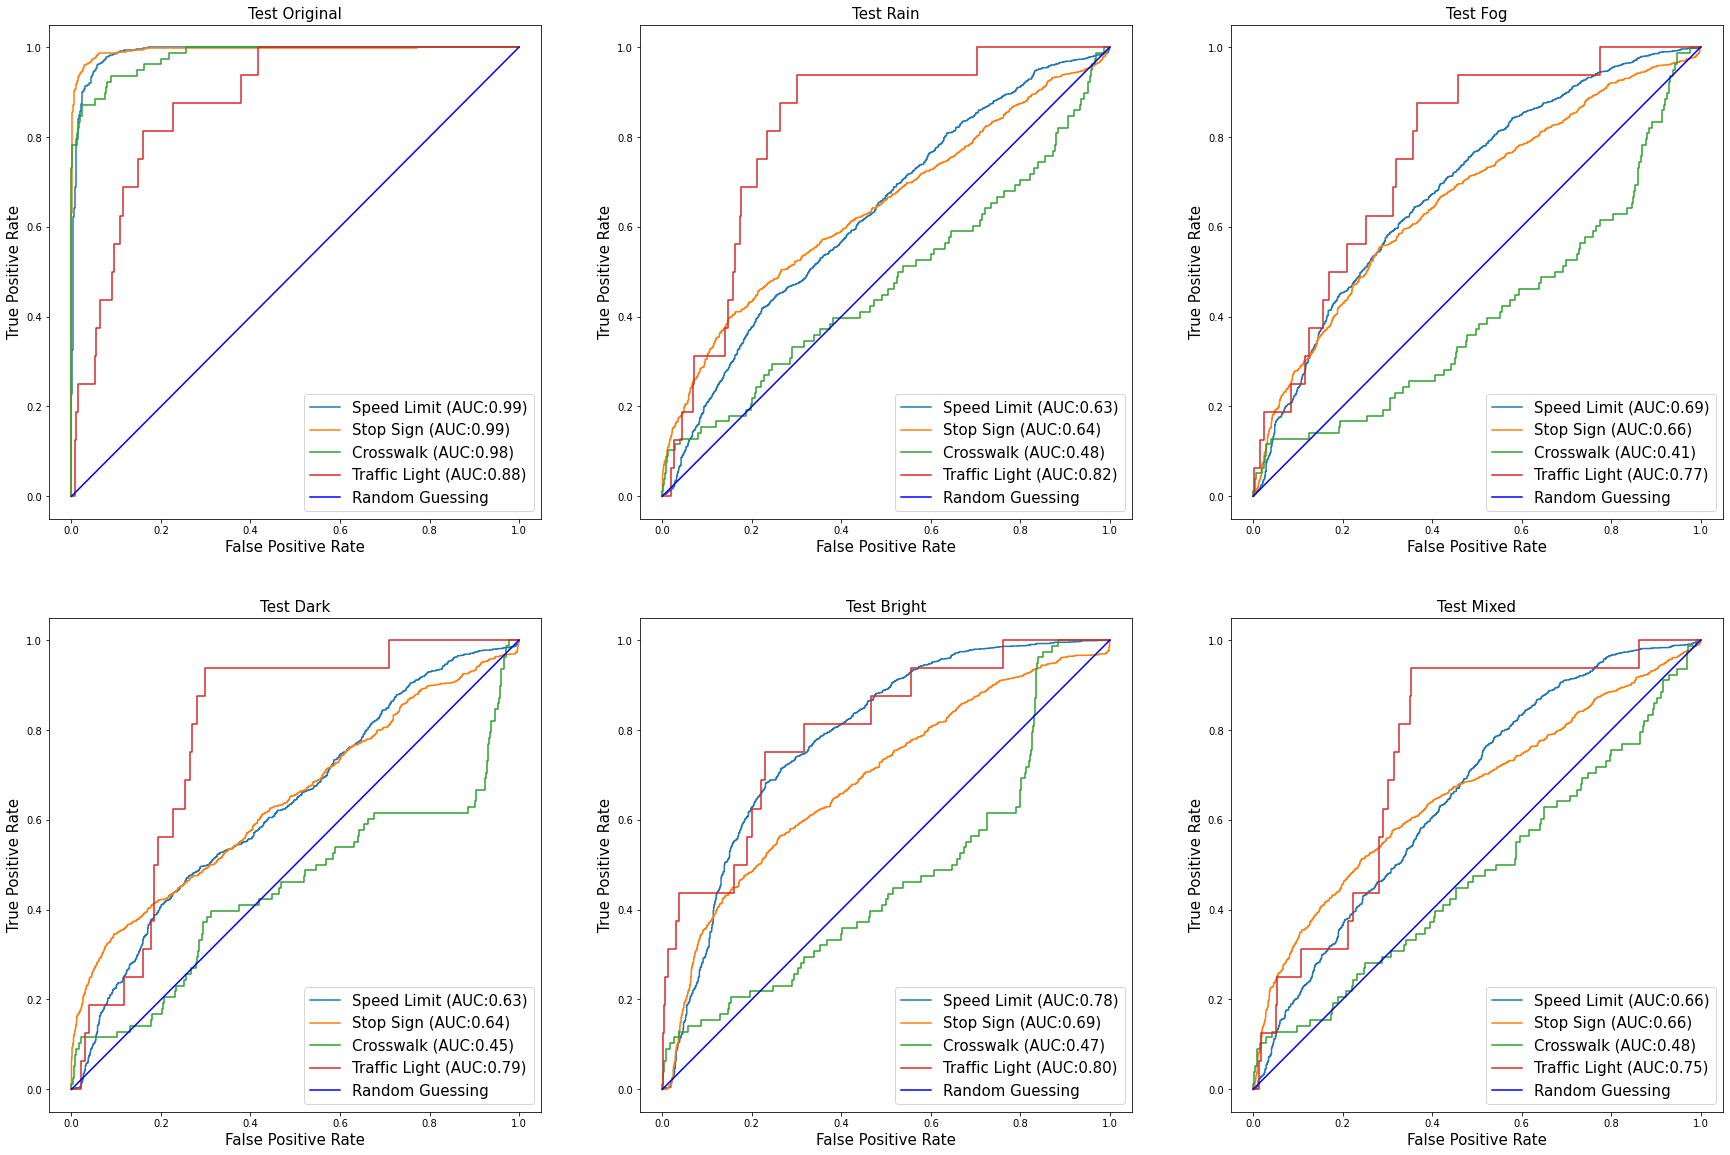

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (30, 20))
# assess validation accuracy on rain
target= [0,1,2,3]

y_pred = model.predict(x_test_all)
auc_ori = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][0], 'Test Original')
print('Original Validation: ROC AUC score:', str(auc_ori))

y_pred = model.predict(x_test_rain)
auc_rain = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][1], 'Test Rain')
print('Rain Validation: ROC AUC score:', str(auc_rain))

y_pred = model.predict(x_test_fog)
auc_fog = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][2], 'Test Fog')
print('Fog Validation: ROC AUC score:', str(auc_fog))

y_pred = model.predict(x_test_dark)
auc_dark = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][0], 'Test Dark')
print('Dark Validation: ROC AUC score:', str(auc_dark))

y_pred = model.predict(x_test_bright)
auc_bright = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][1], 'Test Bright')
print('Bright Validation: ROC AUC score:', str(auc_bright))

y_pred = model.predict(x_test_mixed)
auc_mixed = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][2], 'Test Mixed')
print('Mixed Validation: ROC AUC score:', str(auc_mixed))

auc_lst = [auc_ori, auc_rain, auc_fog, auc_dark, auc_bright, auc_mixed]
AUC['mixed'] = auc_lst

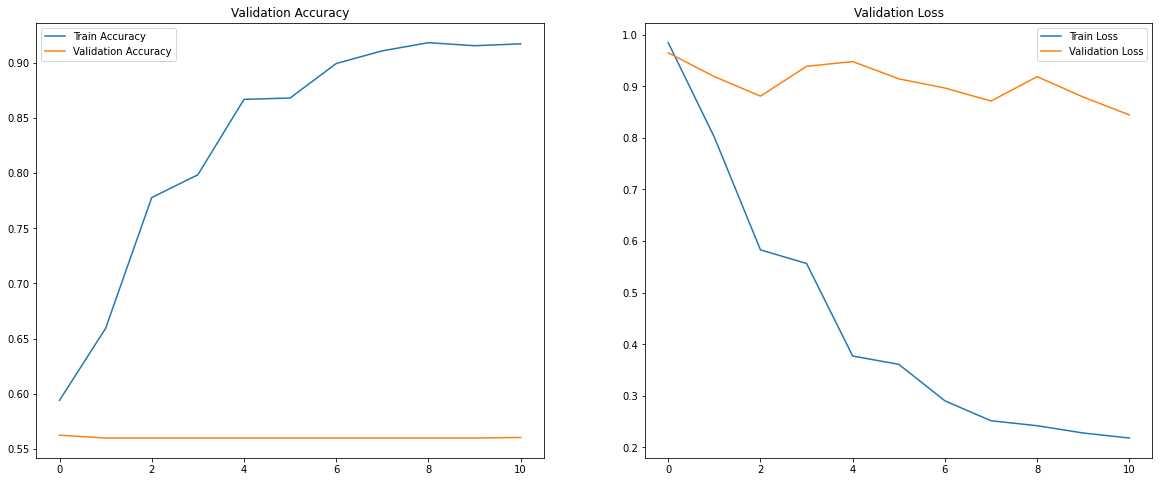

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
# validation accuracy
train_acc =  history_mixed.history['sparse_categorical_accuracy']
val_acc =  history_mixed.history['val_sparse_categorical_accuracy']

# validation loss
train_loss =  history_mixed.history['loss']
val_loss =  history_mixed.history['val_loss']

axes[0].plot(train_acc, label = 'Train Accuracy')
axes[0].plot(val_acc, label = 'Validation Accuracy')
axes[1].plot(train_loss, label = 'Train Loss')
axes[1].plot(val_loss, label = 'Validation Loss')
axes[0].set_title('Validation Accuracy')
axes[1].set_title('Validation Loss')
axes[0].legend()
axes[1].legend()

[Text(69.0, 0.5, 'Actual'), Text(0.5, 42.0, 'Predicted')]

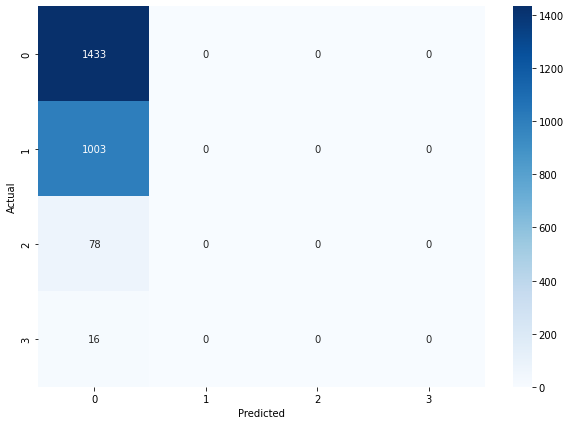

In [ ]:
y_pred = np.argmax(model.predict(x_test_mixed),axis=1)
matrix = confusion_matrix(y_test_all, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
s =sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
s.set(xlabel='Predicted', ylabel='Actual')

# Experimental Setup 3: Dark
* Train data: All Dark
  * 100% Dark Training Images
* Validation data: 
  * Original Validation
  * Rain Validation
  * Fog Validation
  * Dark Validation
  * Bright Validation
* Focus:
  * Check for improvements in classifying dark images

In [ ]:
# generate all dark data
x_train_dark = x_train_all.copy()
x_train_dark = np.array([add_effect(img, 'dark') for img in x_train_dark])

# prepare data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_dark, y_train_all))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# train on mixed train, validated on separate val
# model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
    tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
    tf.keras.layers.Flatten(name = 'flatten'),
    tf.keras.layers.Dropout(0.5, name = '1st_dropout'),
    tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
    tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
    tf.keras.layers.Dense(4, name = '3rd_fc', activation = 'softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_sparse_categorical_accuracy', 
    patience = 10, 
    mode = 'auto'
)

history_dark = model.fit(
    train_dataset,
    epochs=20,
    callbacks = [callbacks],
    verbose=0,
    validation_data=val_dataset,
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Original Validation: ROC AUC score: 0.9724429737306043
Rain Validation: ROC AUC score: 0.725195692643315
Fog Validation: ROC AUC score: 0.7565822819301824
Dark Validation: ROC AUC score: 0.7172327374589201
Bright Validation: ROC AUC score: 0.8032427535279438
Mixed Validation: ROC AUC score: 0.7583850000183804


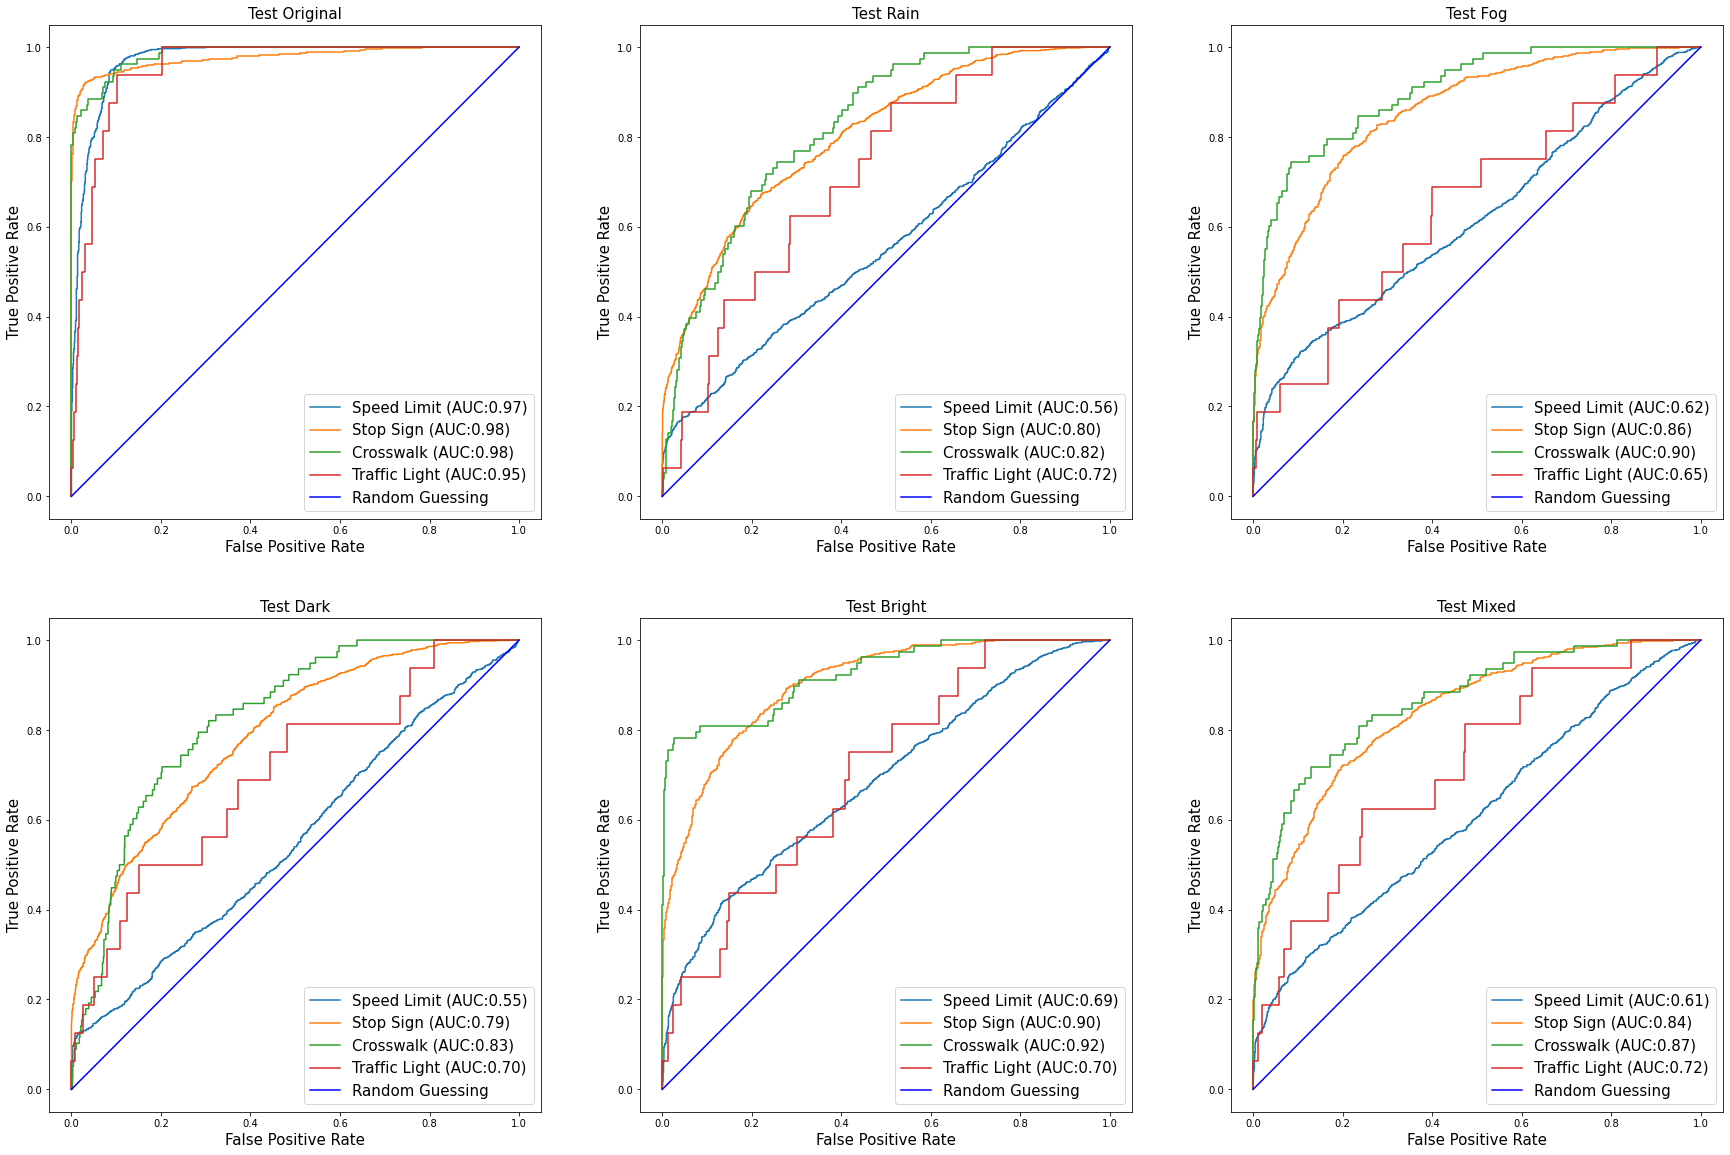

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (30, 20))
# assess validation accuracy on rain
target= [0,1,2,3]

y_pred = model.predict(x_test_all)
auc_ori = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][0], 'Test Original')
print('Original Validation: ROC AUC score:', str(auc_ori))

y_pred = model.predict(x_test_rain)
auc_rain = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][1], 'Test Rain')
print('Rain Validation: ROC AUC score:', str(auc_rain))

y_pred = model.predict(x_test_fog)
auc_fog = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][2], 'Test Fog')
print('Fog Validation: ROC AUC score:', str(auc_fog))

y_pred = model.predict(x_test_dark)
auc_dark = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][0], 'Test Dark')
print('Dark Validation: ROC AUC score:', str(auc_dark))

y_pred = model.predict(x_test_bright)
auc_bright = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][1], 'Test Bright')
print('Bright Validation: ROC AUC score:', str(auc_bright))

y_pred = model.predict(x_test_mixed)
auc_mixed = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][2], 'Test Mixed')
print('Mixed Validation: ROC AUC score:', str(auc_mixed))

auc_lst = [auc_ori, auc_rain, auc_fog, auc_dark, auc_bright, auc_mixed]
AUC['dark'] = auc_lst

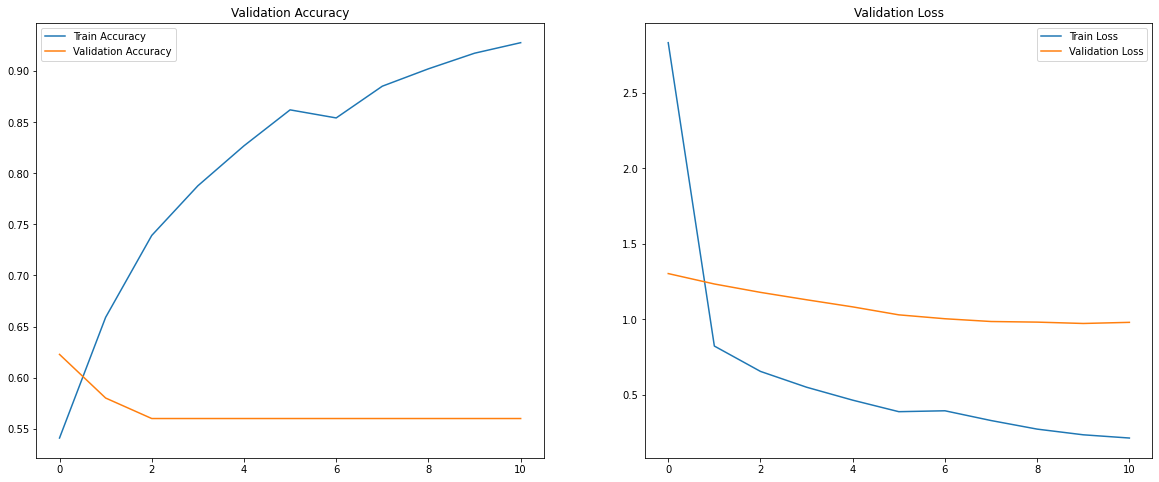

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
# validation accuracy
train_acc =  history_dark.history['sparse_categorical_accuracy']
val_acc =  history_dark.history['val_sparse_categorical_accuracy']

# validation loss
train_loss =  history_dark.history['loss']
val_loss =  history_dark.history['val_loss']

axes[0].plot(train_acc, label = 'Train Accuracy')
axes[0].plot(val_acc, label = 'Validation Accuracy')
axes[1].plot(train_loss, label = 'Train Loss')
axes[1].plot(val_loss, label = 'Validation Loss')
axes[0].set_title('Validation Accuracy')
axes[1].set_title('Validation Loss')
axes[0].legend()
axes[1].legend()

[Text(69.0, 0.5, 'Actual'),
 Text(0.5, 42.0, 'Predicted'),
 Text(0.5, 1.0, 'LeNet on Mixed Testing Confusion Matrix')]

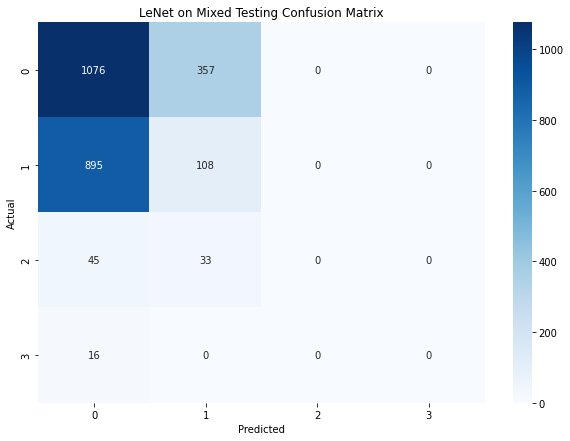

In [ ]:
y_pred = np.argmax(model.predict(x_test_bright),axis=1)
matrix = confusion_matrix(y_test_all, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
s =sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
s.set(xlabel='Predicted', ylabel='Actual', title = 'LeNet on Mixed Testing Confusion Matrix')

# Experimental Setup 4: Rain
* Train data: All Dark
  * 100% Rain Training Images
* Validation data: 
  * Original Validation
  * Rain Validation
  * Fog Validation
  * Dark Validation
  * Bright Validation
* Focus:
  * Check for improvements in classifying rain images

In [ ]:
# generate all rain data
x_train_rain = x_train_all.copy()
x_train_rain = np.array([add_effect(img, 'rain') for img in x_train_rain])

# prepare data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_rain, y_train_all))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# train on mixed train, validated on separate val

# model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
    tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
    tf.keras.layers.Flatten(name = 'flatten'),
    tf.keras.layers.Dropout(0.5, name = '1st_dropout'),
    tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
    tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
    tf.keras.layers.Dense(4, name = '3rd_fc', activation = 'softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_sparse_categorical_accuracy', 
    patience = 10, 
    mode = 'auto'
)

history_rain = model.fit(
    train_dataset,
    epochs=20,
    callbacks = [callbacks],
    verbose=0,
    validation_data=val_dataset,
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Original Validation: ROC AUC score: 0.9671446780492419
Rain Validation: ROC AUC score: 0.6842071392322995
Fog Validation: ROC AUC score: 0.6833764486434489
Dark Validation: ROC AUC score: 0.6592588045639565
Bright Validation: ROC AUC score: 0.7566741613139507
Mixed Validation: ROC AUC score: 0.6725829684347573


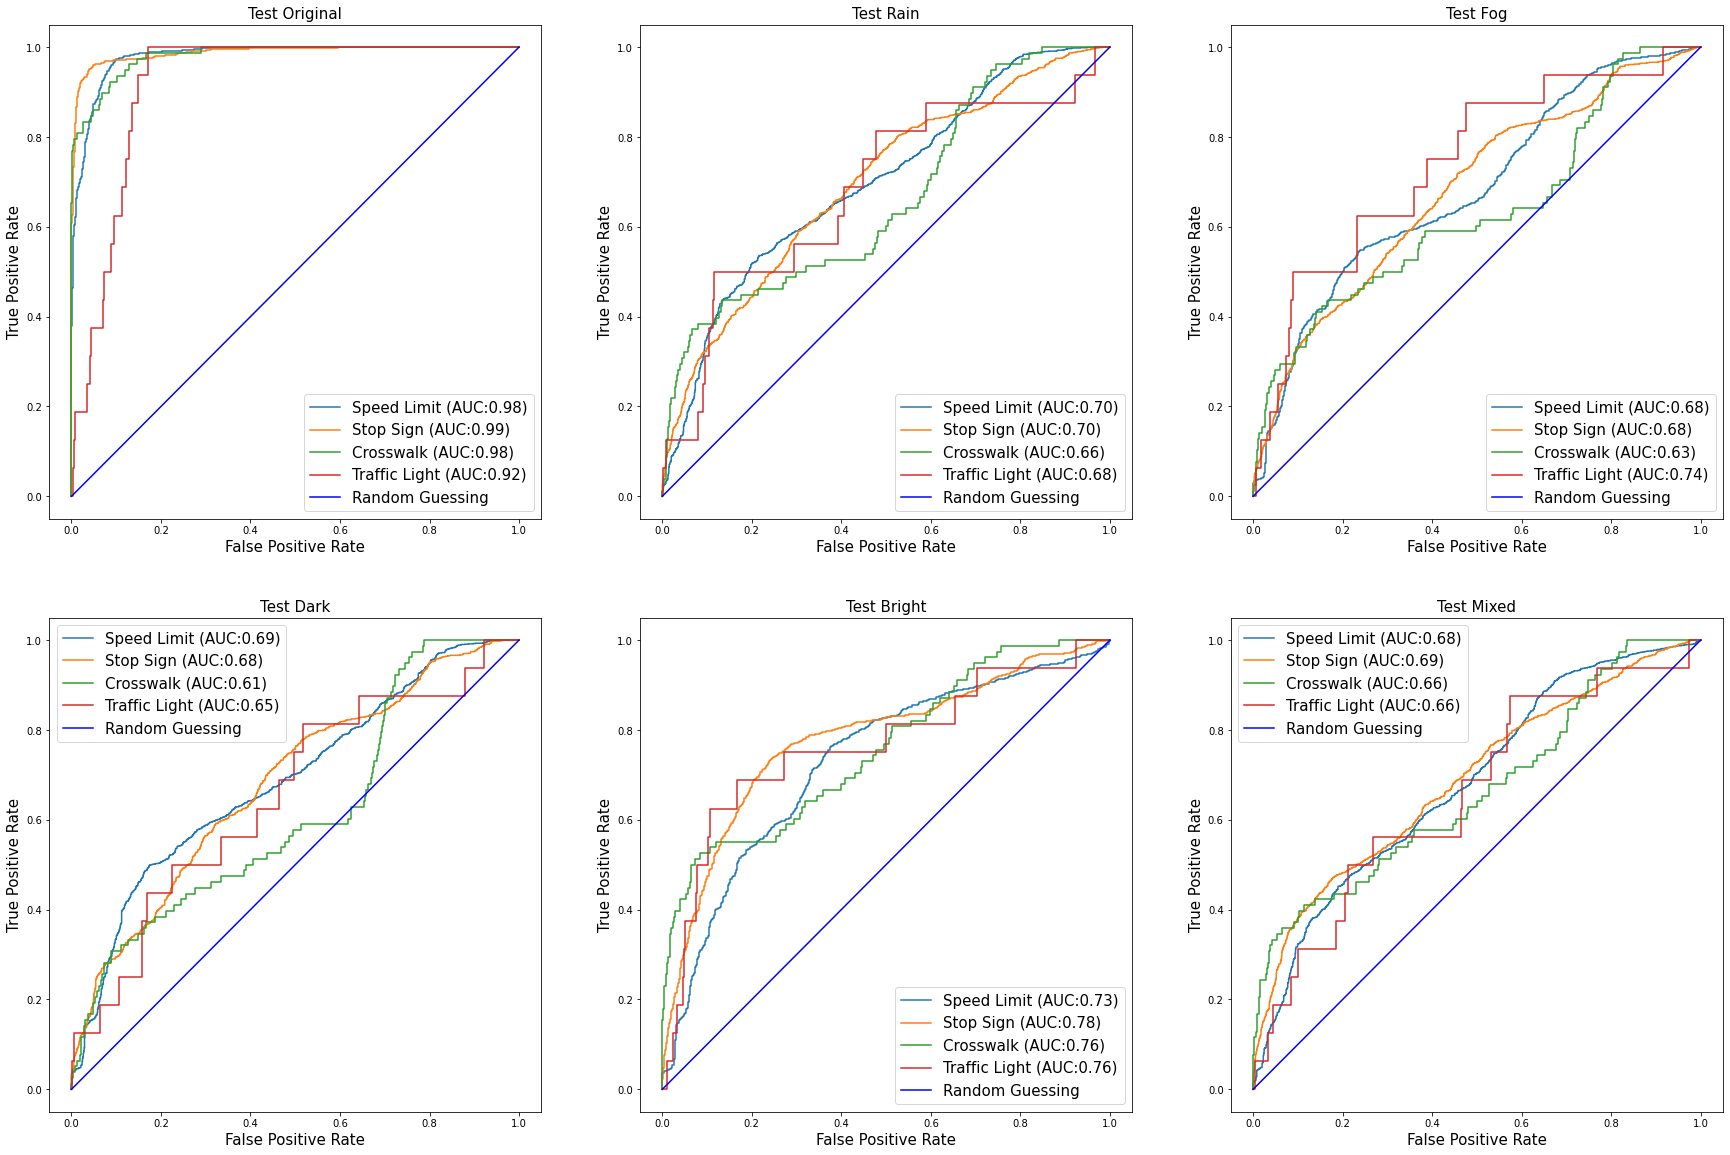

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (30, 20))
# assess validation accuracy on rain
target= [0,1,2,3]

y_pred = model.predict(x_test_all)
auc_ori = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][0], 'Test Original')
print('Original Validation: ROC AUC score:', str(auc_ori))

y_pred = model.predict(x_test_rain)
auc_rain = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][1], 'Test Rain')
print('Rain Validation: ROC AUC score:', str(auc_rain))

y_pred = model.predict(x_test_fog)
auc_fog = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][2], 'Test Fog')
print('Fog Validation: ROC AUC score:', str(auc_fog))

y_pred = model.predict(x_test_dark)
auc_dark = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][0], 'Test Dark')
print('Dark Validation: ROC AUC score:', str(auc_dark))

y_pred = model.predict(x_test_bright)
auc_bright = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][1], 'Test Bright')
print('Bright Validation: ROC AUC score:', str(auc_bright))

y_pred = model.predict(x_test_mixed)
auc_mixed = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][2], 'Test Mixed')
print('Mixed Validation: ROC AUC score:', str(auc_mixed))

auc_lst = [auc_ori, auc_rain, auc_fog, auc_dark, auc_bright, auc_mixed]
AUC['rain'] = auc_lst

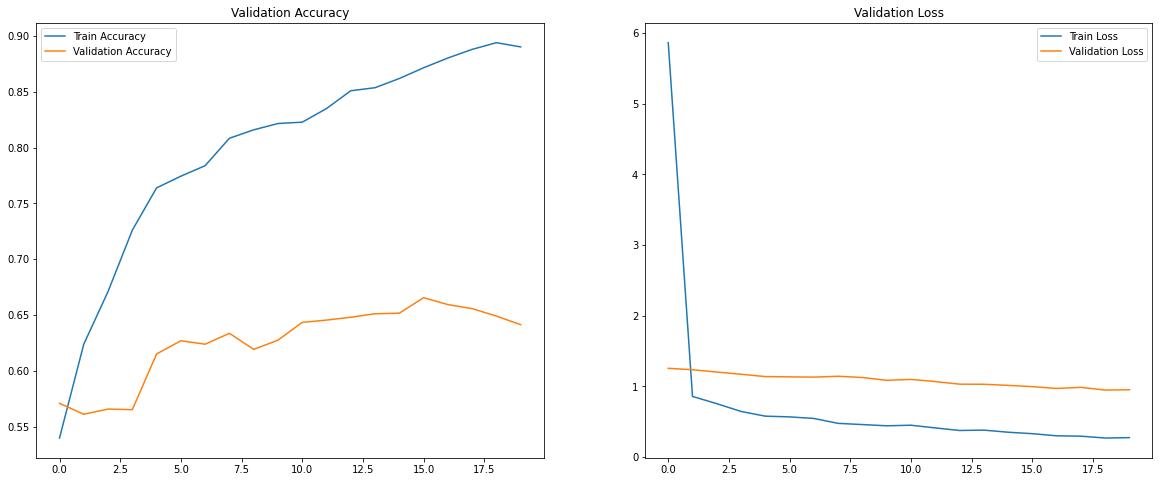

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
# validation accuracy
train_acc =  history_rain.history['sparse_categorical_accuracy']
val_acc =  history_rain.history['val_sparse_categorical_accuracy']

# validation loss
train_loss =  history_rain.history['loss']
val_loss =  history_rain.history['val_loss']

axes[0].plot(train_acc, label = 'Train Accuracy')
axes[0].plot(val_acc, label = 'Validation Accuracy')
axes[1].plot(train_loss, label = 'Train Loss')
axes[1].plot(val_loss, label = 'Validation Loss')
axes[0].set_title('Validation Accuracy')
axes[1].set_title('Validation Loss')
axes[0].legend()
axes[1].legend()

[Text(69.0, 0.5, 'Actual'), Text(0.5, 42.0, 'Predicted')]

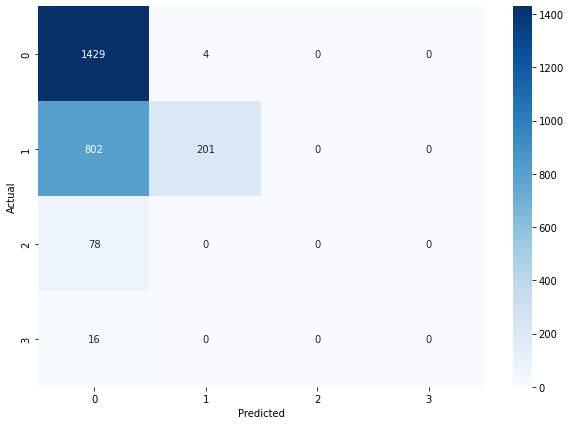

In [ ]:
y_pred = np.argmax(model.predict(x_test_mixed),axis=1)
matrix = confusion_matrix(y_test_all, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
s =sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
s.set(xlabel='Predicted', ylabel='Actual')

# Experimental Setup 5: Fog
* Train data: All Dark
  * 100% Fog Training Images
* Validation data: 
  * Original Validation
  * Rain Validation
  * Fog Validation
  * Dark Validation
  * Bright Validation
* Focus:
  * Check for improvements in classifying fog images

In [ ]:
# generate all fog data
x_train_fog = x_train_all.copy()
x_train_fog = np.array([add_effect(img, 'fog') for img in x_train_fog ])

# prepare data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_fog, y_train_all))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# train on mixed train, validated on separate val

# model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
    tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
    tf.keras.layers.Flatten(name = 'flatten'),
    tf.keras.layers.Dropout(0.5, name = '1st_dropout'),
    tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
    tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
    tf.keras.layers.Dense(4, name = '3rd_fc', activation = 'softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_sparse_categorical_accuracy', 
    patience = 10, 
    mode = 'auto'
)

history_fog = model.fit(
    train_dataset,
    epochs=20,
    callbacks = [callbacks],
    verbose=0,
    validation_data=val_dataset,
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Original Validation: ROC AUC score: 0.9697181996671845
Rain Validation: ROC AUC score: 0.46350655650905687
Fog Validation: ROC AUC score: 0.48754114529877335
Dark Validation: ROC AUC score: 0.4233637186301283
Bright Validation: ROC AUC score: 0.5859625146899651
Mixed Validation: ROC AUC score: 0.487397530230106


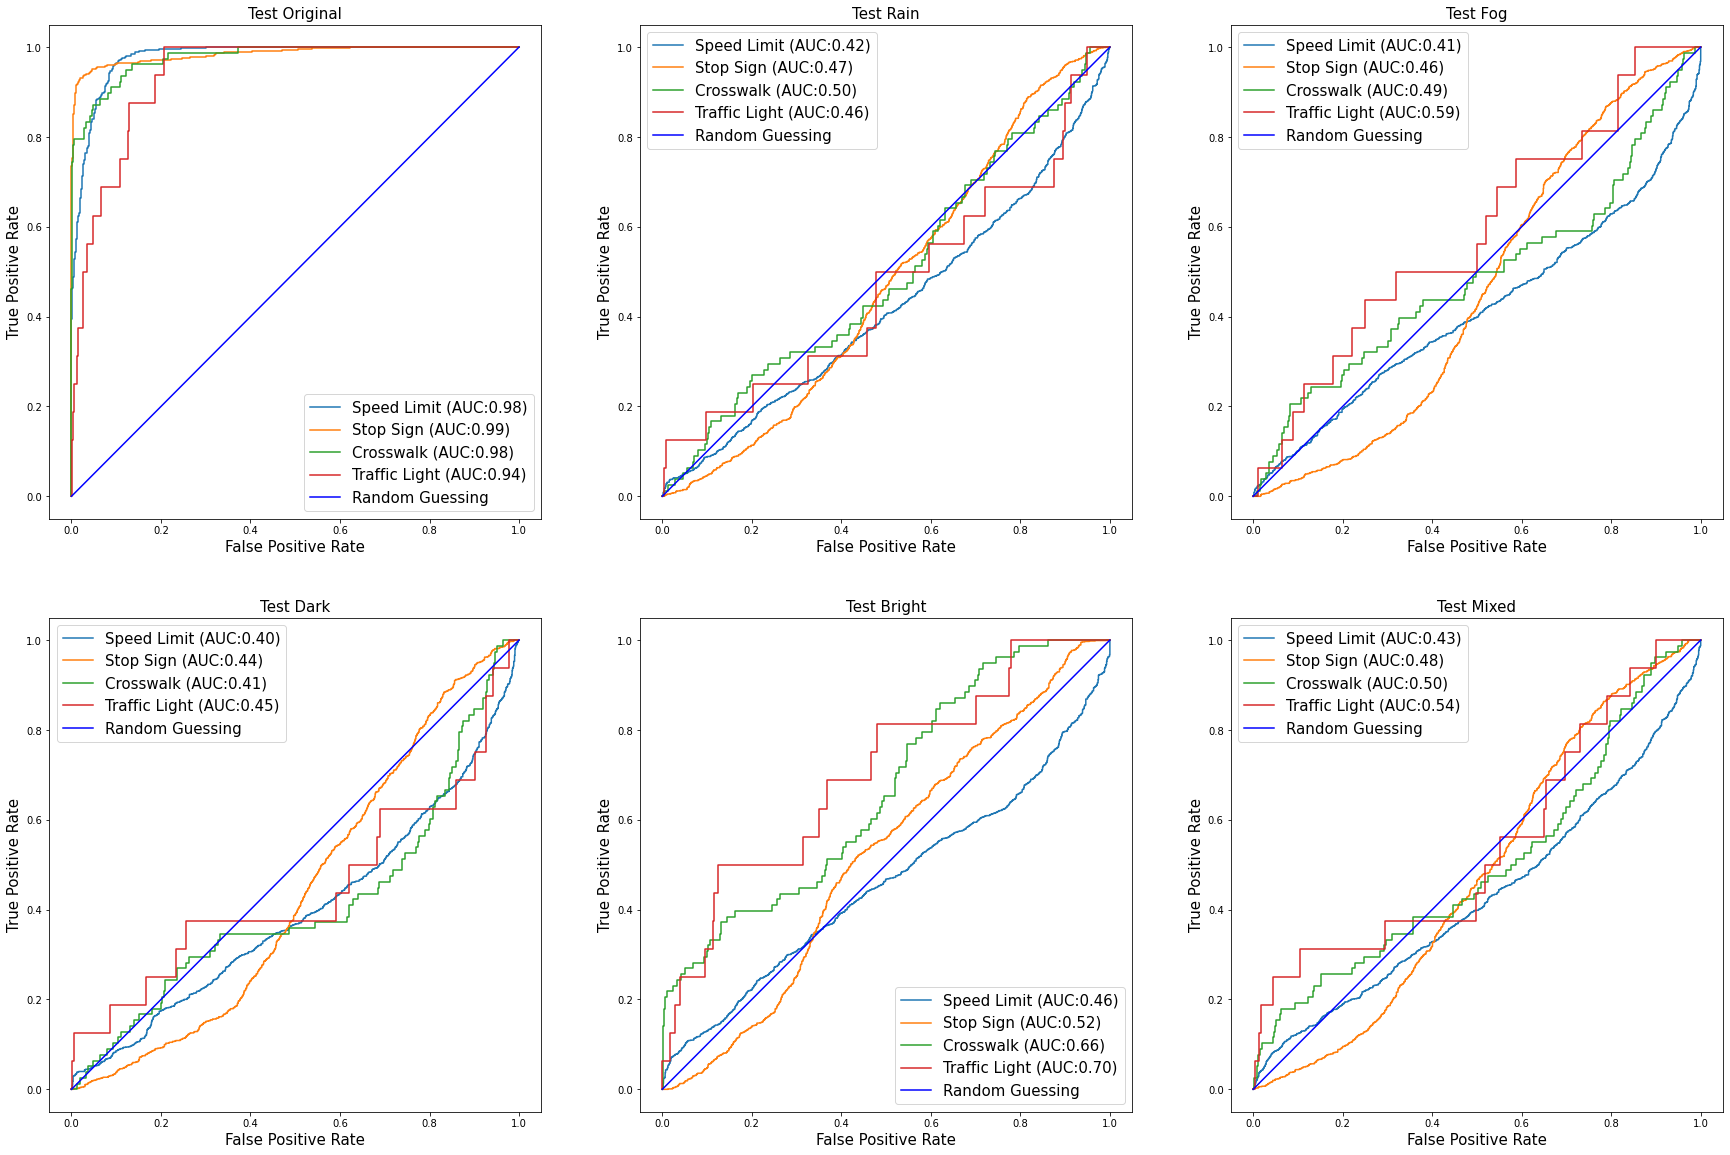

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (30, 20))
# assess validation accuracy on rain
target= [0,1,2,3]

y_pred = model.predict(x_test_all)
auc_ori = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][0], 'Test Original')
print('Original Validation: ROC AUC score:', str(auc_ori))

y_pred = model.predict(x_test_rain)
auc_rain = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][1], 'Test Rain')
print('Rain Validation: ROC AUC score:', str(auc_rain))

y_pred = model.predict(x_test_fog)
auc_fog = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][2], 'Test Fog')
print('Fog Validation: ROC AUC score:', str(auc_fog))

y_pred = model.predict(x_test_dark)
auc_dark = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][0], 'Test Dark')
print('Dark Validation: ROC AUC score:', str(auc_dark))

y_pred = model.predict(x_test_bright)
auc_bright = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][1], 'Test Bright')
print('Bright Validation: ROC AUC score:', str(auc_bright))

y_pred = model.predict(x_test_mixed)
auc_mixed = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][2], 'Test Mixed')
print('Mixed Validation: ROC AUC score:', str(auc_mixed))

auc_lst = [auc_ori, auc_rain, auc_fog, auc_dark, auc_bright, auc_mixed]
AUC['fog'] = auc_lst

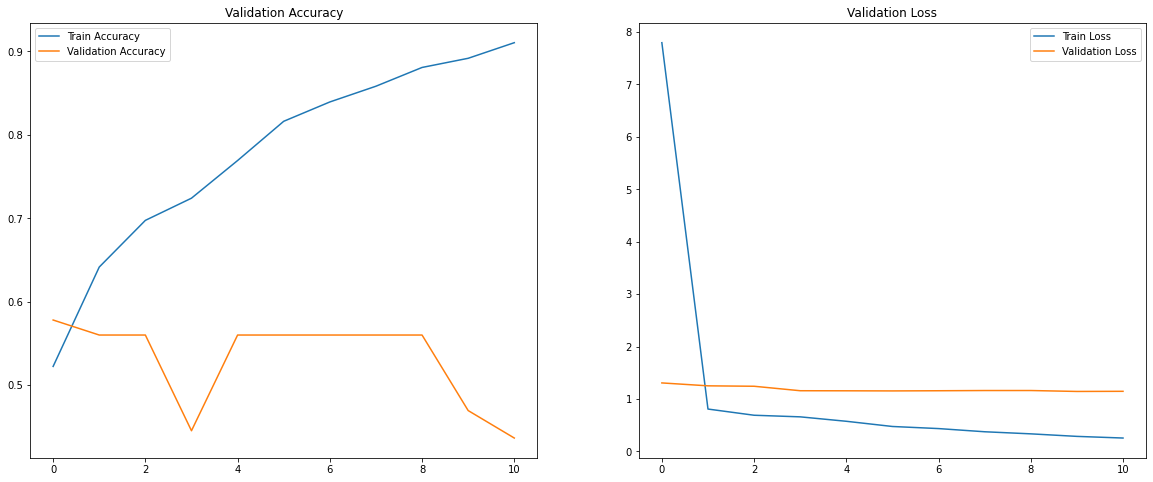

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
# validation accuracy
train_acc =  history_fog.history['sparse_categorical_accuracy']
val_acc =  history_fog.history['val_sparse_categorical_accuracy']

# validation loss
train_loss =  history_fog.history['loss']
val_loss =  history_fog.history['val_loss']

axes[0].plot(train_acc, label = 'Train Accuracy')
axes[0].plot(val_acc, label = 'Validation Accuracy')
axes[1].plot(train_loss, label = 'Train Loss')
axes[1].plot(val_loss, label = 'Validation Loss')
axes[0].set_title('Validation Accuracy')
axes[1].set_title('Validation Loss')
axes[0].legend()
axes[1].legend()

[Text(69.0, 0.5, 'Actual'), Text(0.5, 42.0, 'Predicted')]

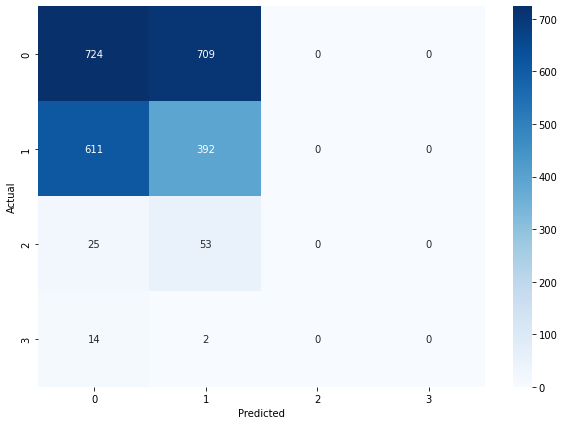

In [ ]:
y_pred = np.argmax(model.predict(x_test_mixed),axis=1)
matrix = confusion_matrix(y_test_all, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
s =sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
s.set(xlabel='Predicted', ylabel='Actual')

# Experimental Setup 6: Bright
* Train data: All Bright
  * 100% Bright Training Images
* Validation data: 
  * Original Validation
  * Rain Validation
  * Fog Validation
  * Dark Validation
  * Bright Validation
* Focus:
  * Check for improvements in classifying bright

In [ ]:
# generate all fog data
x_train_bright = x_train_all.copy()
x_train_bright = np.array([add_effect(img, 'bright') for img in x_train_bright])

# prepare data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_bright, y_train_all))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# train on mixed train, validated on separate val
# model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (48, 48, 3), name = '1st_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '1st_pooling'),
    tf.keras.layers.Conv2D(16, (5, 5), activation = 'relu', name = '2nd_conv'),
    tf.keras.layers.AveragePooling2D(2, 2, name = '2nd_pooling'),
    tf.keras.layers.Flatten(name = 'flatten'),
    tf.keras.layers.Dropout(0.5, name = '1st_dropout'),
    tf.keras.layers.Dense(120,activation='relu', name = '1st_fc'),
    tf.keras.layers.Dense(67,activation='relu', name = '2nd_fc'),
    tf.keras.layers.Dense(4, name = '3rd_fc', activation = 'softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_sparse_categorical_accuracy', 
    patience = 10, 
    mode = 'auto'
)

history_bright = model.fit(
    train_dataset,
    epochs=20,
    callbacks = [callbacks],
    verbose=0,
    validation_data=val_dataset,
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Original Validation: ROC AUC score: 0.973986414521985
Rain Validation: ROC AUC score: 0.5850680137088863
Fog Validation: ROC AUC score: 0.616010707653589
Dark Validation: ROC AUC score: 0.58058875856435
Bright Validation: ROC AUC score: 0.6858052515341198
Mixed Validation: ROC AUC score: 0.6261878587343173


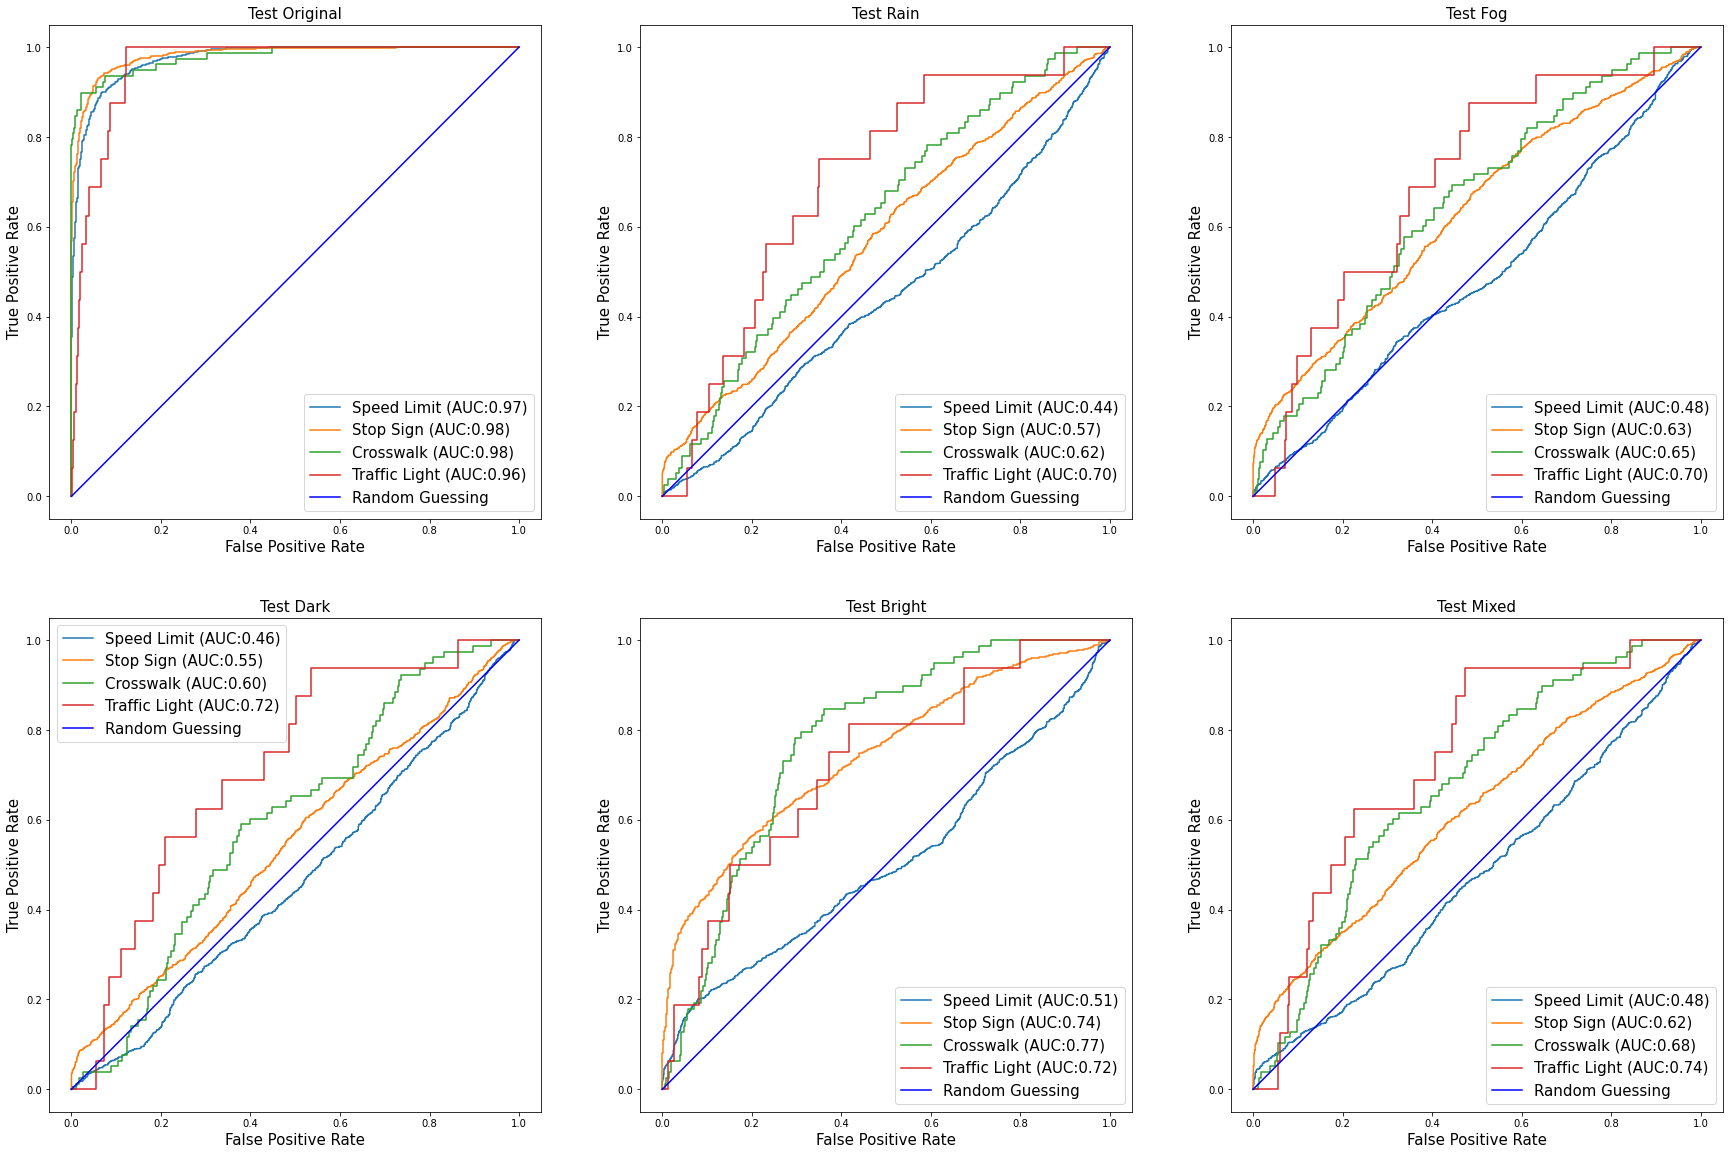

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (30, 20))
# assess validation accuracy on rain
target= [0,1,2,3]

y_pred = model.predict(x_test_all)
auc_ori = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][0], 'Test Original')
print('Original Validation: ROC AUC score:', str(auc_ori))

y_pred = model.predict(x_test_rain)
auc_rain = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][1], 'Test Rain')
print('Rain Validation: ROC AUC score:', str(auc_rain))

y_pred = model.predict(x_test_fog)
auc_fog = multiclass_roc_auc_score(y_test_all, y_pred, axes[0][2], 'Test Fog')
print('Fog Validation: ROC AUC score:', str(auc_fog))

y_pred = model.predict(x_test_dark)
auc_dark = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][0], 'Test Dark')
print('Dark Validation: ROC AUC score:', str(auc_dark))

y_pred = model.predict(x_test_bright)
auc_bright = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][1], 'Test Bright')
print('Bright Validation: ROC AUC score:', str(auc_bright))

y_pred = model.predict(x_test_mixed)
auc_mixed = multiclass_roc_auc_score(y_test_all, y_pred, axes[1][2], 'Test Mixed')
print('Mixed Validation: ROC AUC score:', str(auc_mixed))

auc_lst = [auc_ori, auc_rain, auc_fog, auc_dark, auc_bright, auc_mixed]
AUC['bright'] = auc_lst

In [ ]:
row_names = ['original', 'rain', 'fog', 'dark', 'bright', 'mixed']
df = pd.DataFrame(AUC, index = row_names)
df.to_csv('Test_AUC.csv')

In [ ]:
df = round(df, 3)

In [ ]:
df = df.reset_index(drop = False).rename(columns = {'index':'Testing Dataset'})

In [ ]:
df = df.set_index('Testing Dataset')

In [ ]:
df

,original,mixed,rain,fog,dark,bright
Testing Dataset,,,,,,
original,0.970,0.961,0.967,0.960,0.972,0.974
rain,0.635,0.641,0.684,0.590,0.725,0.585
fog,0.652,0.633,0.683,0.683,0.757,0.616
dark,0.643,0.627,0.659,0.574,0.717,0.581
bright,0.717,0.685,0.757,0.722,0.803,0.686
mixed,0.682,0.637,0.673,0.653,0.758,0.626


In [ ]:
mean_row = df.mean()
mean_row

original    0.7175
mixed       0.6710
rain        0.8475
fog         0.7720
dark        0.7235
bright      0.7825
dtype: float64

In [ ]:
row = round(pd.DataFrame(mean_row).rename(columns = {0: 'Average AUC'}).transpose(), 3)

In [ ]:
df = df.append(row)

In [ ]:
df

,original,mixed,rain,fog,dark,bright
original,0.976,0.971,0.976,0.975,0.977,0.963
rain,0.594,0.610,0.808,0.681,0.625,0.732
fog,0.681,0.599,0.817,0.736,0.679,0.729
dark,0.608,0.626,0.796,0.675,0.654,0.735
bright,0.777,0.614,0.878,0.826,0.735,0.785
mixed,0.669,0.606,0.810,0.739,0.671,0.751
Average AUC,0.717,0.671,0.848,0.772,0.723,0.783


[Text(69.0, 0.5, 'Actual'),
 Text(0.5, 42.0, 'Predicted'),
 Text(0.5, 1.0, 'LeNet on Mixed Testing Dataset Confusion Matrix')]

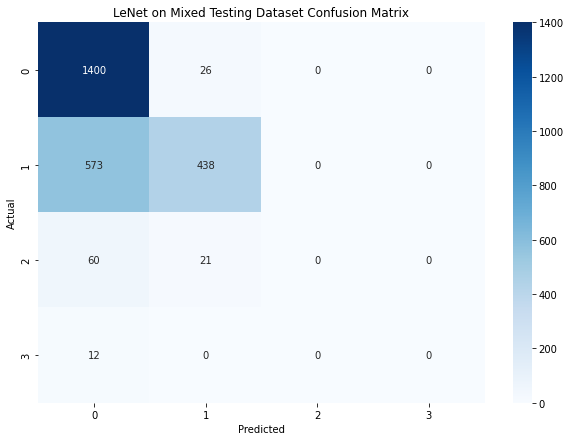

In [ ]:
y_pred = np.argmax(model.predict(x_test_rain),axis=1)
matrix = confusion_matrix(y_test_all, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
s =sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
s.set(xlabel='Predicted', ylabel='Actual', title = 'LeNet on Mixed Testing Dataset Confusion Matrix')